In [1]:
write_images = False


wirte_output_txt = False 
# Specify everytime Simulation is called 
# WARNING --> Set to False when running more then 10 simulations 
#            (otherwise it will be super slow and might crash)

In [2]:
import numpy as np

In [3]:
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign

import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

import matplotlib.pyplot as plt
import mlai.plot as plot

In [4]:
%run Missile_utils.ipynb

In [5]:
simulation_output = 'range' # For now only this is implemented
# We divide by 1000 to avoid dealing with too large numbers

In [6]:
run_grid_simulation = False # If true takes much longer and does 3D plots and so on
run_sensitivity_with_simulator = False

We consider missiles with only 1 stage

In [7]:

basic_param_spaces = {
    'payload':  [10, 2410],
    'missilediam':  [0.1, 9.9],
    'rvdiam':  [0.1, 9.9],
    'estrange': [100, 4900], 
    'fuelmass': [500, 6000], # [500, 7000], 
    'drymass':  [1000, 3000],
    'Isp0':  [100, 800],# [100, 800],
    'thrust0':  [10000, 69000],
}

# 0. Only one param - m0

In [8]:
m0_param_1 = 'fuelmass'
m0_domain_param_1 = basic_param_spaces[m0_param_1] # [500, 6000] # [5000,15000]

m0_space = ParameterSpace(
          [ContinuousParameter(m0_param_1, *m0_domain_param_1), 
          ])

custom_param_names = [m0_param_1]

In [9]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
        
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y



New simulation 

fuelmass: 5242.82294791886


Stage 1 burnout
Velocity (km/s):  1.9903792953322164
Angle (deg h):  43.653884107503636
Range (km):  41.675461425731314
Time (sec):  129.09999999999695
Final results: 
Range (km):  520.2324392116852
Apogee (km):  164.88793338522623
Time to target (sec):  470.6000000000385




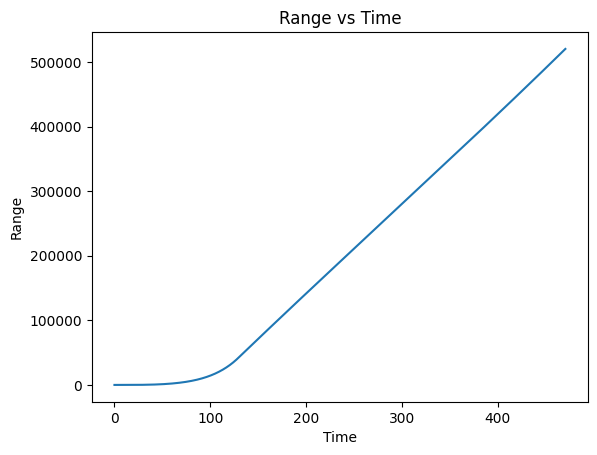

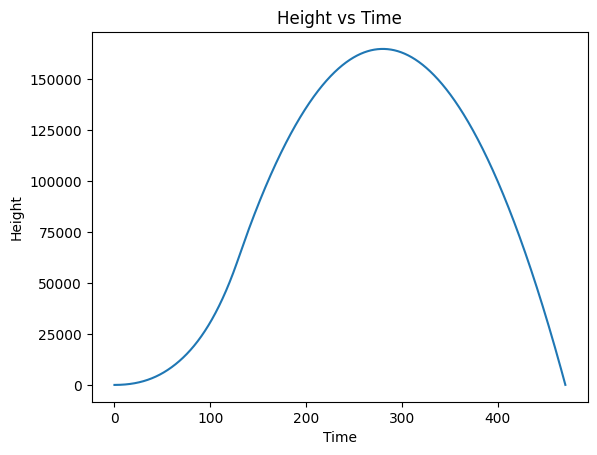

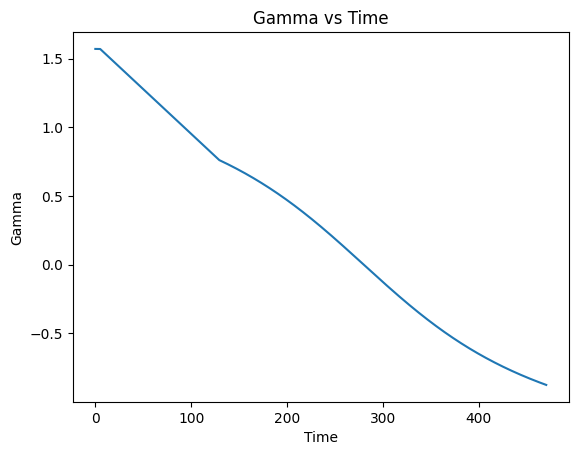

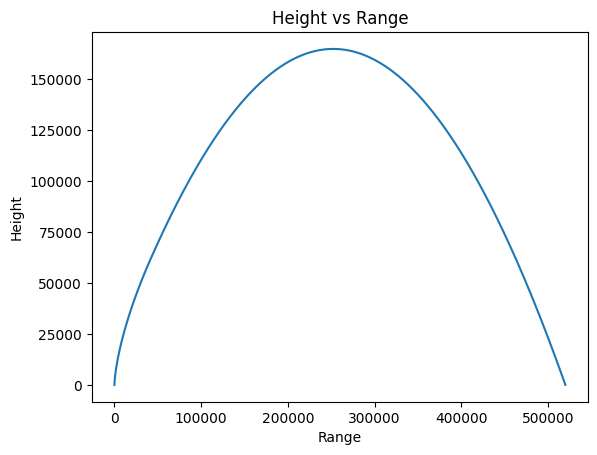

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 1702.7331165873675


Stage 1 burnout
Velocity (km/s):  1.013662149200856
Angle (deg h):  43.65037911089072
Range (km):  8.971327732404324
Time (sec):  42.00000000000033
Final results: 
Range (km):  129.24031518409146
Apogee (km):  41.006555365407685
Time to target (sec):  207.09999999999252




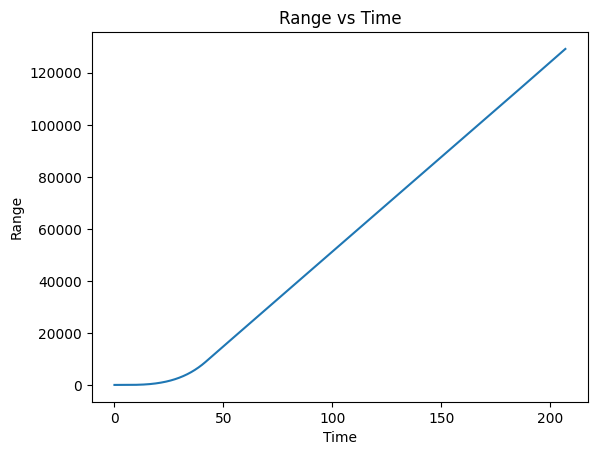

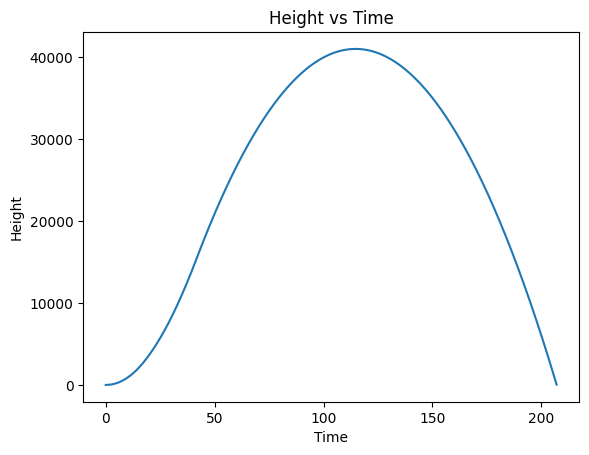

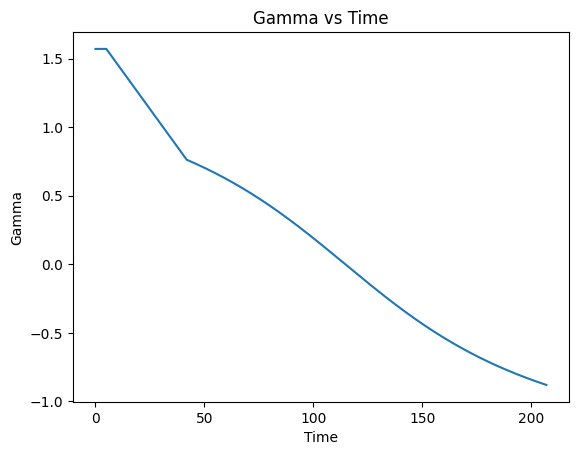

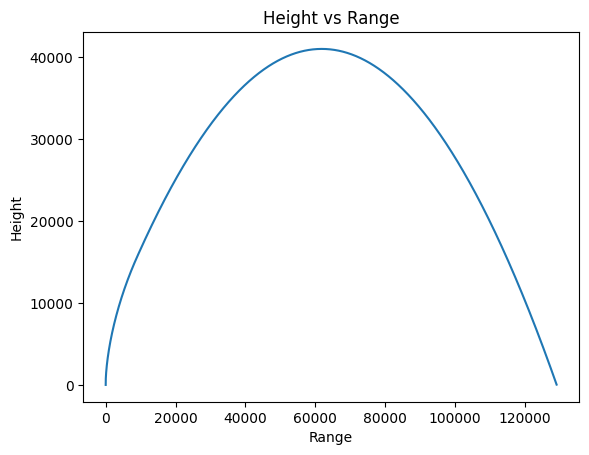

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 4895.664494319145


Stage 1 burnout
Velocity (km/s):  1.9406173106335238
Angle (deg h):  43.65521039348194
Range (km):  38.918639958036145
Time (sec):  120.59999999999742
Final results: 
Range (km):  492.6266331346403
Apogee (km):  155.9989735470059
Time to target (sec):  452.2000000000343




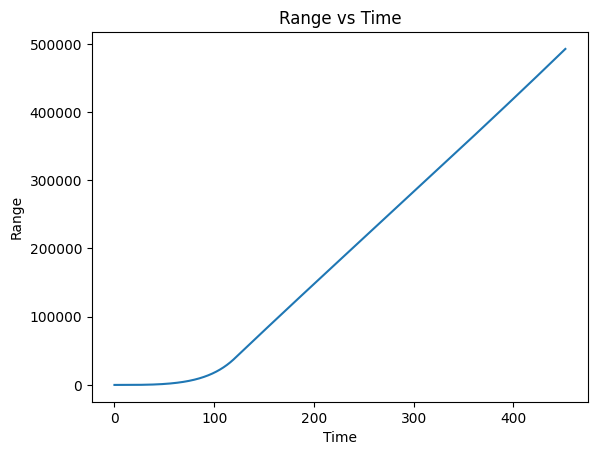

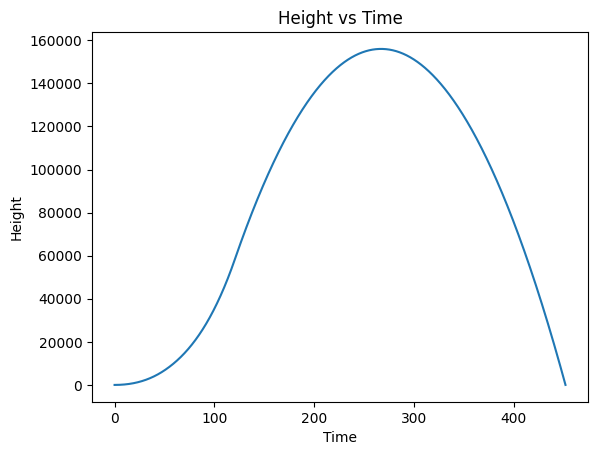

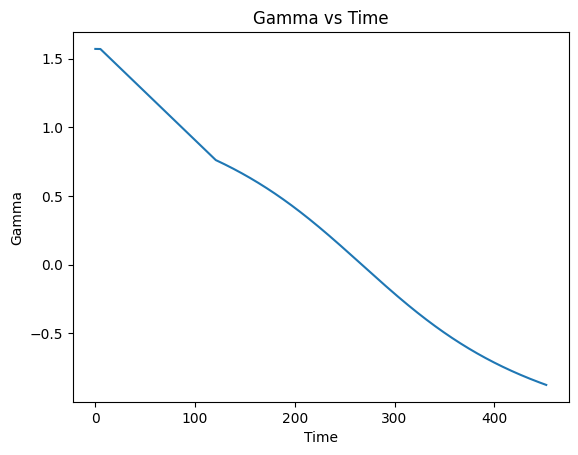

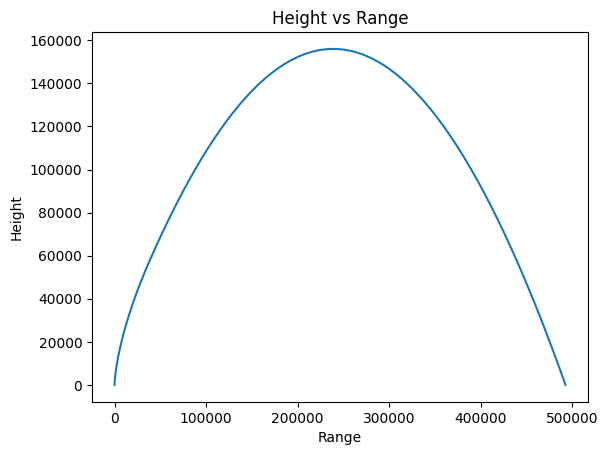

Data written to 'results/results_2.txt'

New simulation 

fuelmass: 3376.5014961583297


Stage 1 burnout
Velocity (km/s):  1.6150328973663066
Angle (deg h):  43.655858714342294
Range (km):  24.84245655332633
Time (sec):  83.19999999999955
Final results: 
Range (km):  334.48742002827834
Apogee (km):  105.55334113741077
Time to target (sec):  352.90000000001174




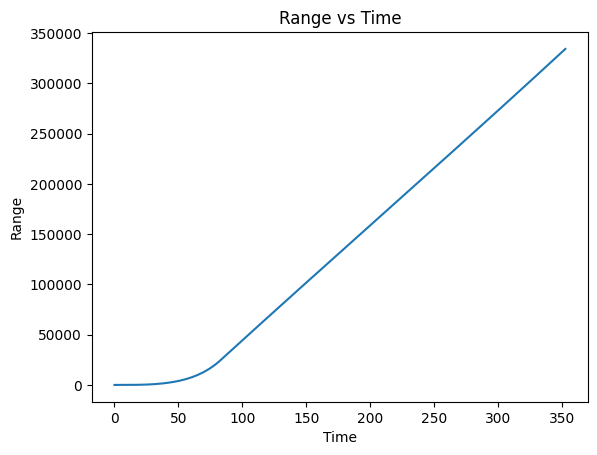

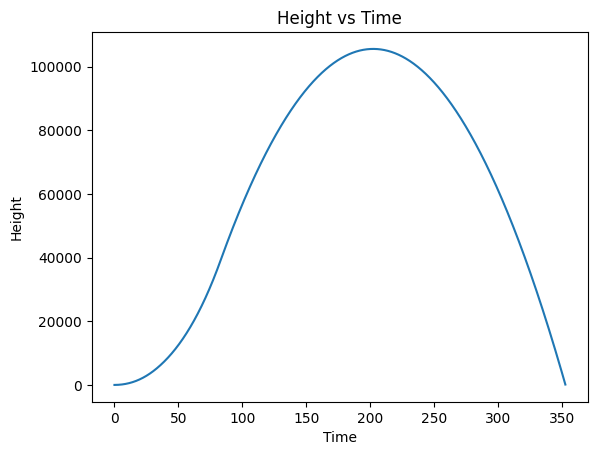

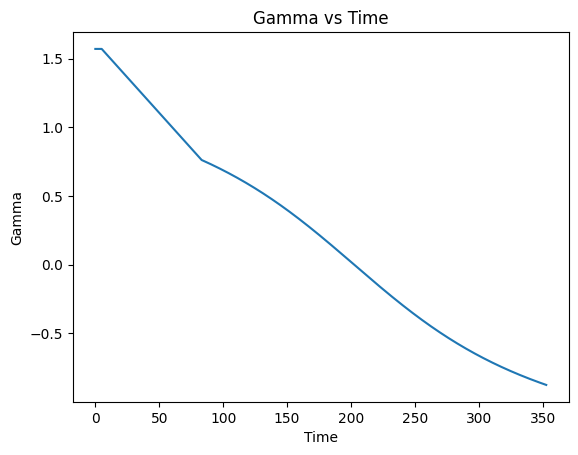

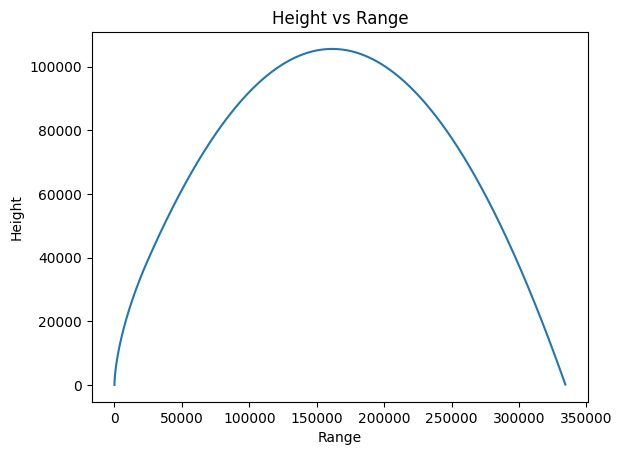

Data written to 'results/results_3.txt'

New simulation 

fuelmass: 4995.08999478036


Stage 1 burnout
Velocity (km/s):  1.9538989569159277
Angle (deg h):  43.653807544577575
Range (km):  39.67924149990021
Time (sec):  122.99999999999729
Final results: 
Range (km):  499.90390530553253
Apogee (km):  158.41138979761993
Time to target (sec):  457.20000000003546




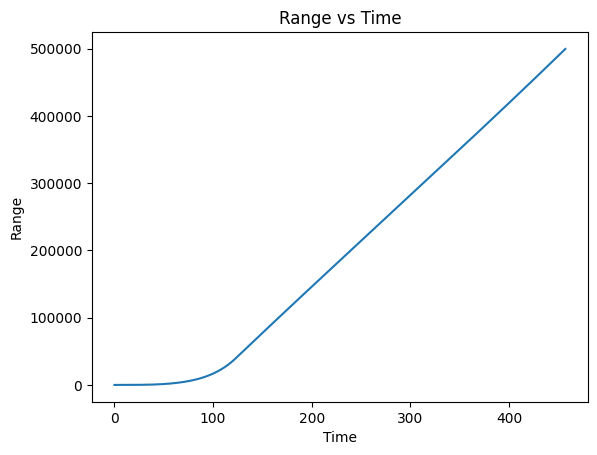

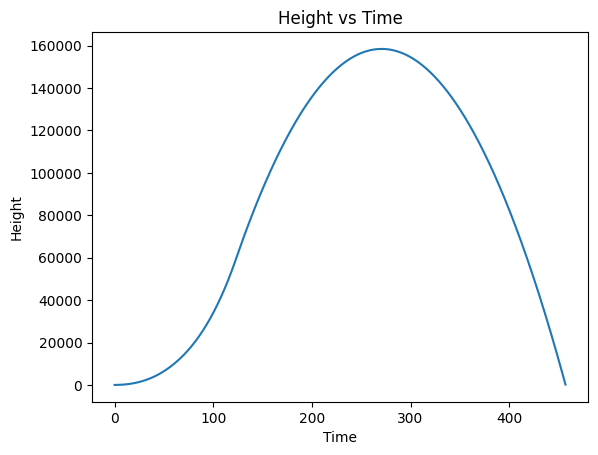

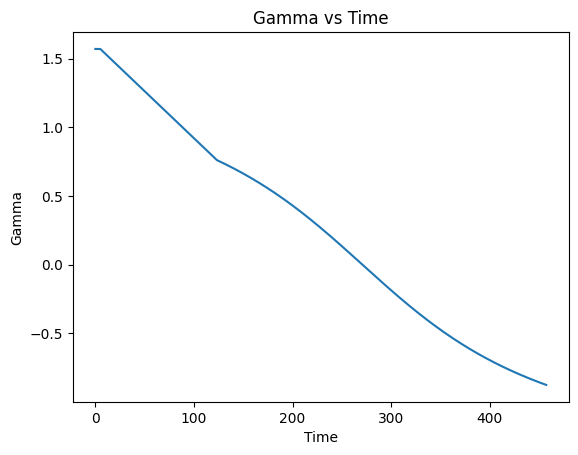

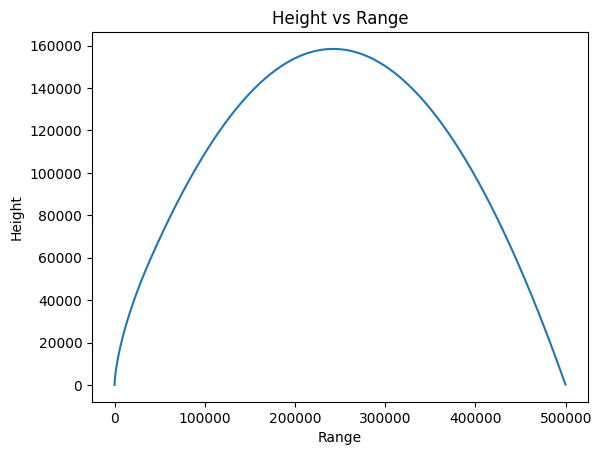

Data written to 'results/results_4.txt'


In [10]:
# Get true points (to build model)
wirte_output_txt = True

m0_design = RandomDesign(m0_space)
m0_x = m0_design.get_samples(5)
m0_y = run_missile_sim(m0_x)

In [11]:
# Build model
m0_var_kernel = (100)**2 
m0_lengthscale = 100 # 1
m0_var_linear_kernel = (100)**2 
# In catapult: RBF kernel is set to 150^2 because that’s roughly the square of the range of the catapult
m0_var_noise = 1e-5 # small value
# In catapult: 1e-5

#kern = GPy.kern.RBF(input_dim=1, lengthscale=100, variance =var_kernel )  # , lengthscale=0.08, variance=20
# kern = GPy.kern.Matern32(input_dim=1)
# kern = GPy.kern.Linear(input_dim=1)
m0_kern = GPy.kern.RBF(input_dim=1, lengthscale=m0_lengthscale ) + \
    GPy.kern.Linear(input_dim=1)

m0_model_gpy = GPRegression(m0_x,m0_y, kernel=m0_kern)
m0_model_gpy.kern.variance =  m0_var_kernel 
m0_model_gpy.likelihood.variance.fix(m0_var_noise)  

# Add constraints ?
# Add priors ?
# Change Kernel
# Change variances values

display(m0_model_gpy)



In [12]:
# Fit emulator
m0_model_emukit = GPyModelWrapper(m0_model_gpy)
m0_model_emukit.optimize() # Optimize model hyperparameters



In [13]:
display(m0_model_gpy)

In [14]:
# Get true points corresponding to param_1_x_plot (for plot)
wirte_output_txt = False

nr_points_plot = 301
m0_param_1_x_plot = np.linspace(m0_space.parameters[0].min, m0_space.parameters[0].max, nr_points_plot)[:, None]
m0_param_1_y_plot = run_missile_sim(m0_param_1_x_plot)




New simulation 

fuelmass: 500.0


Stage 1 burnout
Velocity (km/s):  0.4265056287972526
Angle (deg h):  43.732284489193205
Range (km):  0.9440400159604505
Time (sec):  12.299999999999974
Final results: 
Range (km):  21.661219962904816
Apogee (km):  6.737492515662497
Time to target (sec):  79.59999999999975



New simulation 

fuelmass: 518.3333333333334


Stage 1 burnout
Velocity (km/s):  0.43905877485586203
Angle (deg h):  43.94232680213815
Range (km):  1.037682082180261
Time (sec):  12.799999999999972
Final results: 
Range (km):  23.013791615632808
Apogee (km):  7.19665589314658
Time to target (sec):  82.3999999999996



New simulation 

fuelmass: 536.6666666666666


Stage 1 burnout
Velocity (km/s):  0.44799024767022866
Angle (deg h):  43.73993108354109
Range (km):  1.1013774296045882
Time (sec):  13.19999999999997
Final results: 
Range (km):  24.02034604907838
Apogee (km):  7.485179947127214
Time to target (sec):  84.0999999999995



New simulation 

fuelmass: 555.0


Stage 1 burno

Final results: 
Range (km):  65.47851793270273
Apogee (km):  20.71032911508845
Time to target (sec):  143.39999999999614



New simulation 

fuelmass: 1086.6666666666665


Stage 1 burnout
Velocity (km/s):  0.7376295471833686
Angle (deg h):  43.72386243762432
Range (km):  4.244312578447072
Time (sec):  26.800000000000114
Final results: 
Range (km):  67.40006304156974
Apogee (km):  21.344939443798882
Time to target (sec):  145.699999999996



New simulation 

fuelmass: 1105.0


Stage 1 burnout
Velocity (km/s):  0.7444357860029703
Angle (deg h):  43.67461673135336
Range (km):  4.3408570642132
Time (sec):  27.20000000000012
Final results: 
Range (km):  68.664093576499
Apogee (km):  21.751216727163865
Time to target (sec):  147.09999999999593



New simulation 

fuelmass: 1123.3333333333333


Stage 1 burnout
Velocity (km/s):  0.7547895811826383
Angle (deg h):  43.726071767921454
Range (km):  4.49237733290142
Time (sec):  27.700000000000127
Final results: 
Range (km):  70.62512765184988
Apog

Stage 1 burnout
Velocity (km/s):  0.9981656793815111
Angle (deg h):  43.65979613872028
Range (km):  8.66987308346248
Time (sec):  41.200000000000315
Final results: 
Range (km):  125.24056989745291
Apogee (km):  39.789429493572065
Time to target (sec):  203.6999999999927



New simulation 

fuelmass: 1691.6666666666665


Stage 1 burnout
Velocity (km/s):  1.0078764061683527
Angle (deg h):  43.68520091188962
Range (km):  8.858275087596908
Time (sec):  41.70000000000032
Final results: 
Range (km):  127.72820045740487
Apogee (km):  40.578391819299966
Time to target (sec):  205.8999999999926



New simulation 

fuelmass: 1710.0


Stage 1 burnout
Velocity (km/s):  1.0136045025050158
Angle (deg h):  43.66325277639398
Range (km):  8.974661928864137
Time (sec):  42.10000000000033
Final results: 
Range (km):  129.28352858817843
Apogee (km):  41.057102397684474
Time to target (sec):  207.2999999999925



New simulation 

fuelmass: 1728.3333333333333


Stage 1 burnout
Velocity (km/s):  1.0232816569

Final results: 
Range (km):  181.13245531479143
Apogee (km):  57.38600238892058
Time to target (sec):  249.19999999999013



New simulation 

fuelmass: 2168.333333333333


Stage 1 burnout
Velocity (km/s):  1.201637233651066
Angle (deg h):  43.710602106921925
Range (km):  13.038274337593714
Time (sec):  53.40000000000049
Final results: 
Range (km):  182.6788267734642
Apogee (km):  57.978367542167184
Time to target (sec):  250.59999999999005



New simulation 

fuelmass: 2186.6666666666665


Stage 1 burnout
Velocity (km/s):  1.211067213871199
Angle (deg h):  43.66394580623868
Range (km):  13.25004685357554
Time (sec):  53.900000000000496
Final results: 
Range (km):  185.63348232888663
Apogee (km):  58.79699129514629
Time to target (sec):  252.59999999998993



New simulation 

fuelmass: 2205.0


Stage 1 burnout
Velocity (km/s):  1.216111769751961
Angle (deg h):  43.712088081491125
Range (km):  13.375013605326387
Time (sec):  54.3000000000005
Final results: 
Range (km):  187.1903988968262

Final results: 
Range (km):  254.64070309442425
Apogee (km):  80.47607875468076
Time to target (sec):  301.40000000000003



New simulation 

fuelmass: 2755.0


Stage 1 burnout
Velocity (km/s):  1.4231967645190102
Angle (deg h):  43.65571037302037
Range (km):  18.70512511424092
Time (sec):  67.90000000000042
Final results: 
Range (km):  257.7257449040164
Apogee (km):  81.35307986197594
Time to target (sec):  303.20000000000044



New simulation 

fuelmass: 2773.333333333333


Stage 1 burnout
Velocity (km/s):  1.427069690060069
Angle (deg h):  43.69326929044682
Range (km):  18.83232983596492
Time (sec):  68.3000000000004
Final results: 
Range (km):  259.24771961642153
Apogee (km):  81.9252589007249
Time to target (sec):  304.50000000000074



New simulation 

fuelmass: 2791.6666666666665


Stage 1 burnout
Velocity (km/s):  1.4355514392392486
Angle (deg h):  43.657649840081355
Range (km):  19.06255750694612
Time (sec):  68.80000000000037
Final results: 
Range (km):  262.34585942714125
Ap

Stage 1 burnout
Velocity (km/s):  1.5827710302883793
Angle (deg h):  43.67862473993936
Range (km):  23.732862287574672
Time (sec):  80.4999999999997
Final results: 
Range (km):  320.87665162782696
Apogee (km):  101.30930344900209
Time to target (sec):  344.50000000000983



New simulation 

fuelmass: 3286.6666666666665


Stage 1 burnout
Velocity (km/s):  1.5903363815192733
Angle (deg h):  43.648810282686895
Range (km):  23.96947910853838
Time (sec):  80.99999999999967
Final results: 
Range (km):  323.9952408914824
Apogee (km):  102.18699316330729
Time to target (sec):  346.2000000000102



New simulation 

fuelmass: 3305.0


Stage 1 burnout
Velocity (km/s):  1.5931093639914449
Angle (deg h):  43.67996950229402
Range (km):  24.09166333221533
Time (sec):  81.39999999999965
Final results: 
Range (km):  325.2532490096263
Apogee (km):  102.69674606615989
Time to target (sec):  347.30000000001047



New simulation 

fuelmass: 3323.333333333333


Stage 1 burnout
Velocity (km/s):  1.6006102242

Final results: 
Range (km):  377.8062639054711
Apogee (km):  119.22816570769305
Time to target (sec):  379.9000000000179



New simulation 

fuelmass: 3763.333333333333


Stage 1 burnout
Velocity (km/s):  1.7139988578684504
Angle (deg h):  43.66801323888249
Range (km):  28.59112490701802
Time (sec):  92.69999999999901
Final results: 
Range (km):  378.74441178709185
Apogee (km):  119.66970031501373
Time to target (sec):  380.8000000000181



New simulation 

fuelmass: 3781.6666666666665


Stage 1 burnout
Velocity (km/s):  1.720763721465991
Angle (deg h):  43.64237675811696
Range (km):  28.828033030286655
Time (sec):  93.19999999999898
Final results: 
Range (km):  381.8055326064831
Apogee (km):  120.5259901069684
Time to target (sec):  382.40000000001845



New simulation 

fuelmass: 3800.0


Stage 1 burnout
Velocity (km/s):  1.7226680479100107
Angle (deg h):  43.669277743564564
Range (km):  28.941091818797073
Time (sec):  93.59999999999896
Final results: 
Range (km):  382.86175928917675

Final results: 
Range (km):  428.35932314107947
Apogee (km):  135.46056650520958
Time to target (sec):  411.6000000000251



New simulation 

fuelmass: 4240.0


Stage 1 burnout
Velocity (km/s):  1.8185121188671796
Angle (deg h):  43.656873589495156
Range (km):  33.050371406448896
Time (sec):  104.39999999999834
Final results: 
Range (km):  429.11856982767335
Apogee (km):  135.74506834585645
Time to target (sec):  412.30000000002525



New simulation 

fuelmass: 4258.333333333333


Stage 1 burnout
Velocity (km/s):  1.8246285685877355
Angle (deg h):  43.65995449880955
Range (km):  33.28291758469607
Time (sec):  104.89999999999831
Final results: 
Range (km):  432.02000434249976
Apogee (km):  136.6478030478444
Time to target (sec):  413.9000000000256



New simulation 

fuelmass: 4276.666666666666


Stage 1 burnout
Velocity (km/s):  1.82582711384989
Angle (deg h):  43.65817861218147
Range (km):  33.38418707542493
Time (sec):  105.29999999999829
Final results: 
Range (km):  432.767594623476

Final results: 
Range (km):  477.15524814815024
Apogee (km):  151.1156479620061
Time to target (sec):  442.5000000000321



New simulation 

fuelmass: 4753.333333333333


Stage 1 burnout
Velocity (km/s):  1.9173471571838383
Angle (deg h):  43.65360713180984
Range (km):  37.71462361349822
Time (sec):  117.09999999999762
Final results: 
Range (km):  480.0644208000098
Apogee (km):  151.96970958572982
Time to target (sec):  444.1000000000325



New simulation 

fuelmass: 4771.666666666666


Stage 1 burnout
Velocity (km/s):  1.9179013290525495
Angle (deg h):  43.65314757328279
Range (km):  37.801354458312076
Time (sec):  117.4999999999976
Final results: 
Range (km):  480.4034501221844
Apogee (km):  152.16401316868914
Time to target (sec):  444.6000000000326



New simulation 

fuelmass: 4790.0


Stage 1 burnout
Velocity (km/s):  1.9233811329468227
Angle (deg h):  43.654707649490504
Range (km):  38.025265181594854
Time (sec):  117.99999999999757
Final results: 
Range (km):  483.3122226310582

Final results: 
Range (km):  522.1588049724447
Apogee (km):  165.4476201011053
Time to target (sec):  471.4000000000387



New simulation 

fuelmass: 5266.666666666666


Stage 1 burnout
Velocity (km/s):  1.9943458628851896
Angle (deg h):  43.66753923153275
Range (km):  41.880856097265934
Time (sec):  129.69999999999692
Final results: 
Range (km):  522.3439771826243
Apogee (km):  165.6246720575841
Time to target (sec):  472.0000000000388



New simulation 

fuelmass: 5285.0


Stage 1 burnout
Velocity (km/s):  1.9993066226217862
Angle (deg h):  43.64948701362865
Range (km):  42.09356203223513
Time (sec):  130.1999999999969
Final results: 
Range (km):  524.9621182874274
Apogee (km):  166.3482766139095
Time to target (sec):  473.3000000000391



New simulation 

fuelmass: 5303.333333333333


Stage 1 burnout
Velocity (km/s):  1.9992520580392321
Angle (deg h):  43.66842490287561
Range (km):  42.162519832787424
Time (sec):  130.59999999999687
Final results: 
Range (km):  525.1383515742538
Apo

Final results: 
Range (km):  558.3504734667251
Apogee (km):  176.93449553359386
Time to target (sec):  496.2000000000443



New simulation 

fuelmass: 5761.666666666666


Stage 1 burnout
Velocity (km/s):  2.0567893710162384
Angle (deg h):  43.66157465855145
Range (km):  45.55951320936524
Time (sec):  141.89999999999623
Final results: 
Range (km):  558.2643956341079
Apogee (km):  177.01725455929076
Time to target (sec):  496.70000000004444



New simulation 

fuelmass: 5780.0


Stage 1 burnout
Velocity (km/s):  2.0612703934925083
Angle (deg h):  43.64514348628608
Range (km):  45.758316241443
Time (sec):  142.3999999999962
Final results: 
Range (km):  560.6739666805945
Apogee (km):  177.6804325331837
Time to target (sec):  497.9000000000447



New simulation 

fuelmass: 5798.333333333333


Stage 1 burnout
Velocity (km/s):  2.060701920352979
Angle (deg h):  43.662416881113785
Range (km):  45.809007394707244
Time (sec):  142.79999999999617
Final results: 
Range (km):  560.5788005024417
Apo

In [15]:
# Get model prediction on param_1_x_plot
m0_mu_plot, m0_var_plot = m0_model_emukit.predict(m0_param_1_x_plot)



In [16]:
# Plot
def helper_plot_emulator_errorbars(x_plot, y_plot, mu_plot, var_plot, model_emukit):
    """Helper function for plotting the emulator fit."""
    ax.plot(model_emukit.X[:, 0], model_emukit.Y, 'ro', markersize=10, label='observations')
    ax.plot(x_plot[:, 0], mu_plot, 'C0', label='model', linewidth=3)
    ax.plot(x_plot[:, 0], y_plot, 'k', label='target function', linewidth=2)
#     ax.fill_between(x_plot[:, index],
#                  mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
#                  mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color='C0', alpha=0.6)
    ax.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.4)
#     ax.fill_between(x_plot[:, index],
#                  mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
#                  mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.2)
    ax.legend(loc=2)
    ax.set_xlabel(custom_param_names[0])
    ax.set_ylabel('$f(x)$')
    ax.grid(True)
    #ax.set_xlim(-0.01, 1)
    #ax.set_ylim([-20, 20])
    

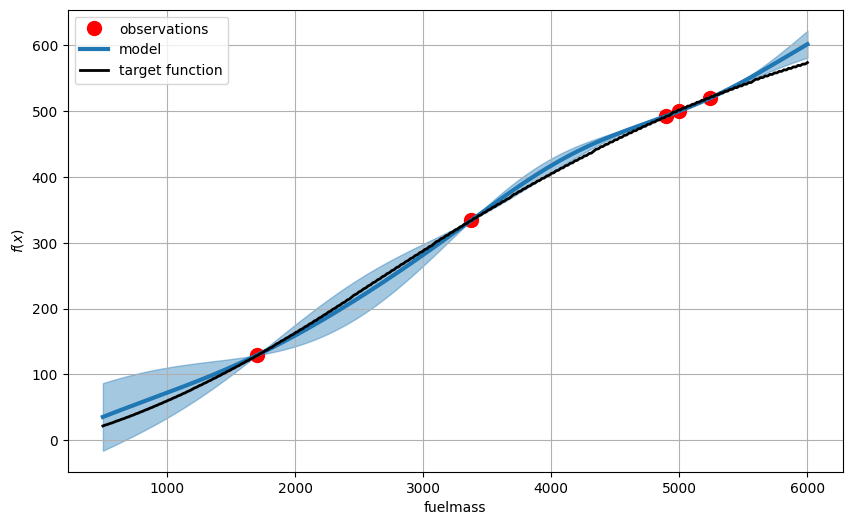

In [17]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
helper_plot_emulator_errorbars(x_plot=m0_param_1_x_plot, y_plot=m0_param_1_y_plot, 
                               mu_plot=m0_mu_plot, var_plot=m0_var_plot, 
                               model_emukit=m0_model_emukit)

# 0. Only one param - m1

In [18]:
m1_param_1 = 'Isp0'
m1_domain_param_1 = basic_param_spaces[m1_param_1] # [500, 6000] # [5000,15000]

m1_space = ParameterSpace(
          [ContinuousParameter(m1_param_1, *m1_domain_param_1), 
          ])

custom_param_names = [m1_param_1]

In [19]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
        
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y



New simulation 

Isp0: 746.1742081708957


Stage 1 burnout
Velocity (km/s):  8.36614946835227
Angle (deg h):  43.6519873004489
Range (km):  569.7774530715061
Time (sec):  455.300000000035
Final results: 
Range (km):  15312.874121089486
Apogee (km):  10744.995035258433
Time to target (sec):  8877.300000014764




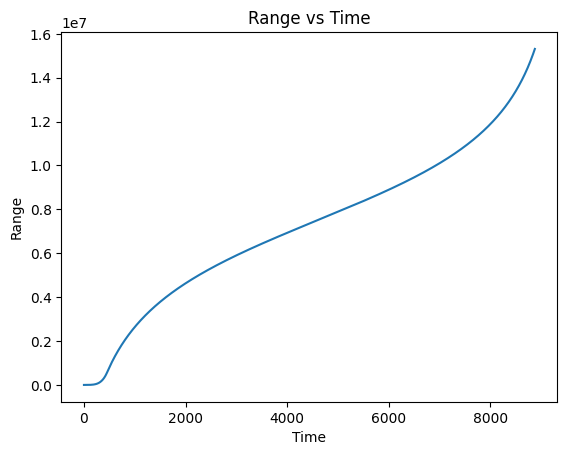

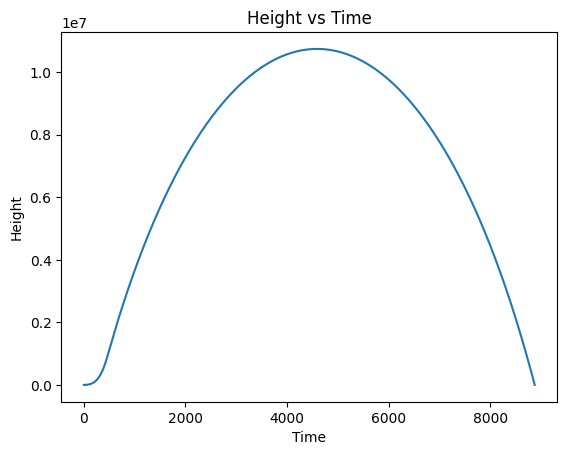

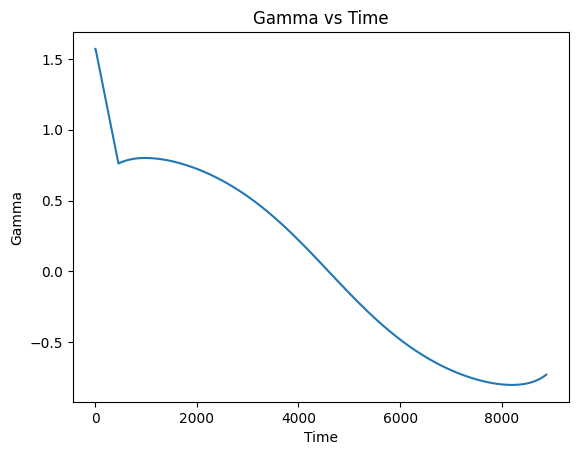

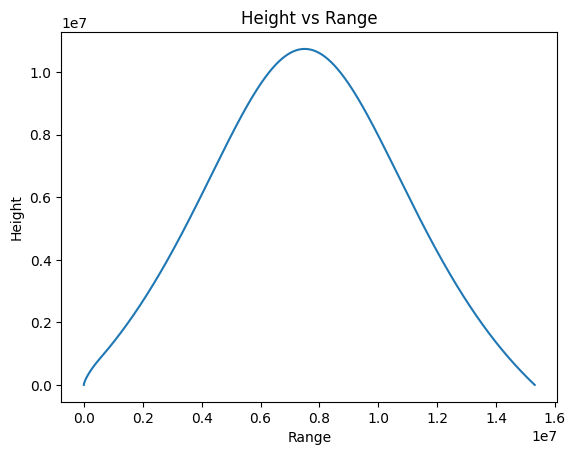

Data written to 'results/results_0.txt'

New simulation 

Isp0: 277.0765885048885


Stage 1 burnout
Velocity (km/s):  2.6051119801009675
Angle (deg h):  43.657286474733894
Range (km):  68.65139500869212
Time (sec):  169.09999999999468
Final results: 
Range (km):  906.1382509170145
Apogee (km):  285.5280323412096
Time to target (sec):  635.1000000000759




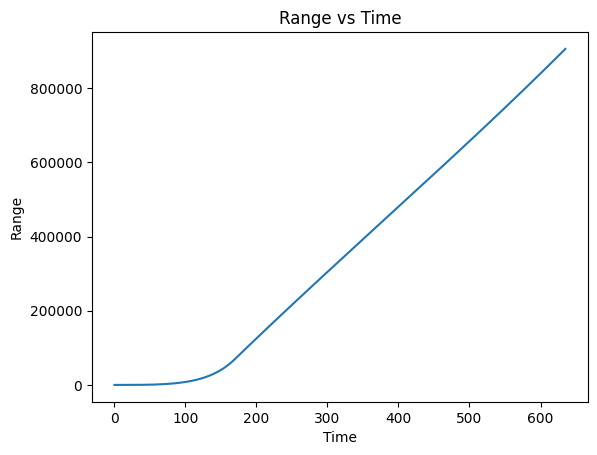

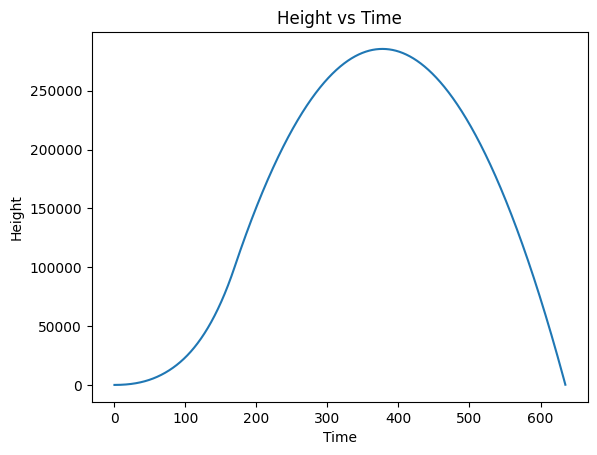

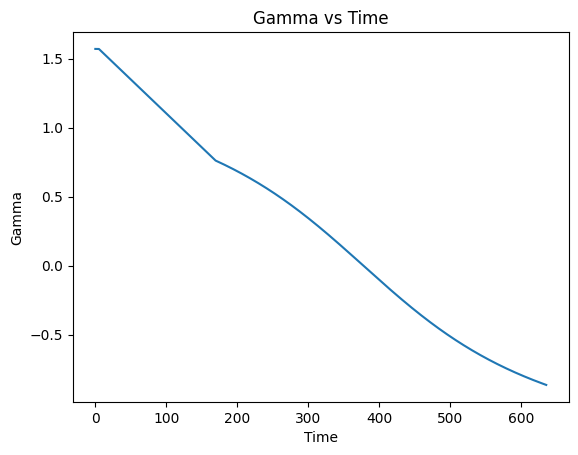

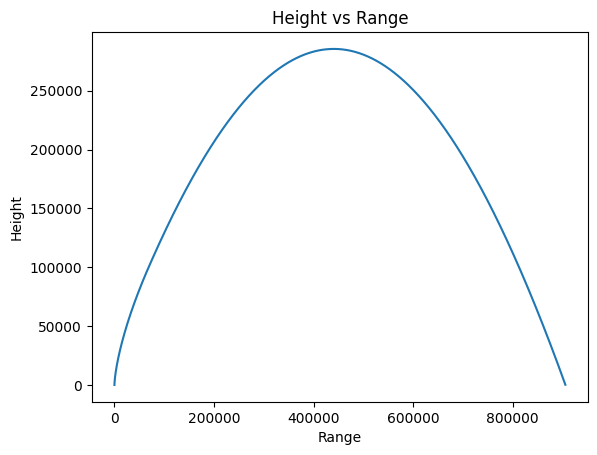

Data written to 'results/results_1.txt'

New simulation 

Isp0: 613.7020908392017


Stage 1 burnout
Velocity (km/s):  6.717674610519414
Angle (deg h):  43.65946081414397
Range (km):  381.37904964230046
Time (sec):  374.50000000001666
Final results: 
Range (km):  8441.78434638953
Apogee (km):  3391.4893628044656
Time to target (sec):  3146.9999999982333




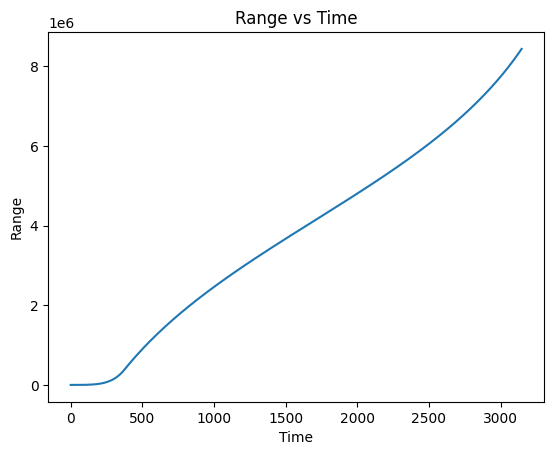

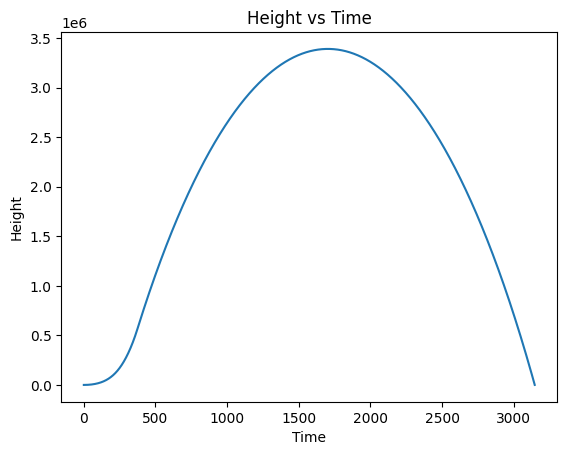

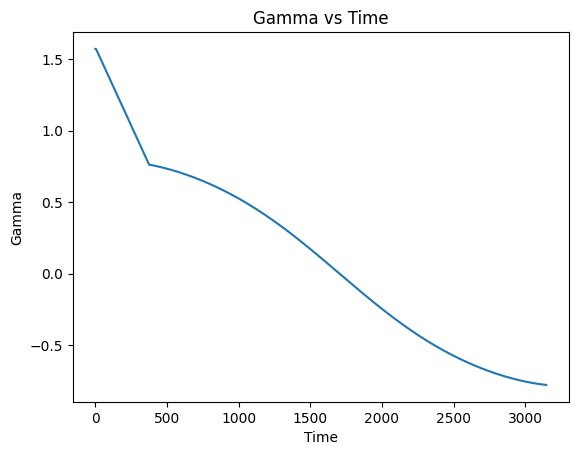

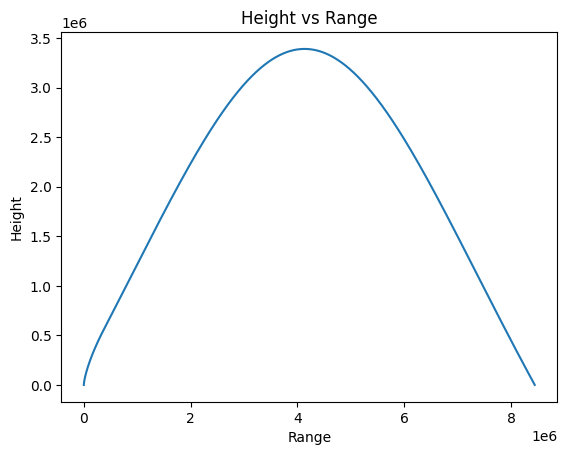

Data written to 'results/results_2.txt'

New simulation 

Isp0: 781.4844596352202


Stage 1 burnout
Velocity (km/s):  8.81504430730173
Angle (deg h):  43.65796401992553
Range (km):  625.7174354888838
Time (sec):  476.90000000003994
Final results: 
Range (km):  17329.89882896413
Apogee (km):  16309.373477959343
Time to target (sec):  13641.500000032096




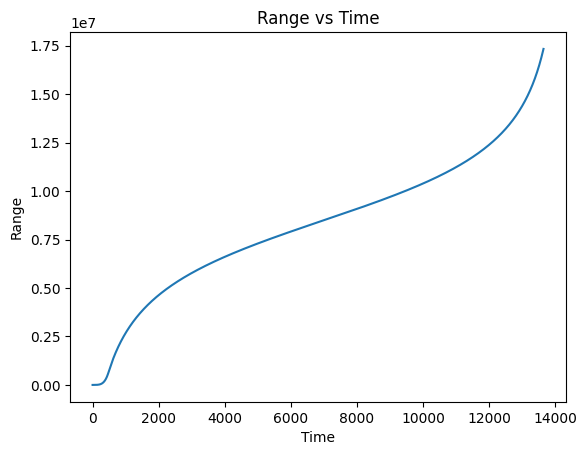

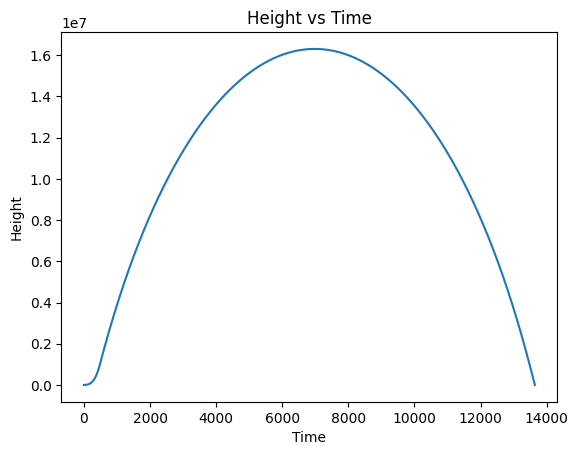

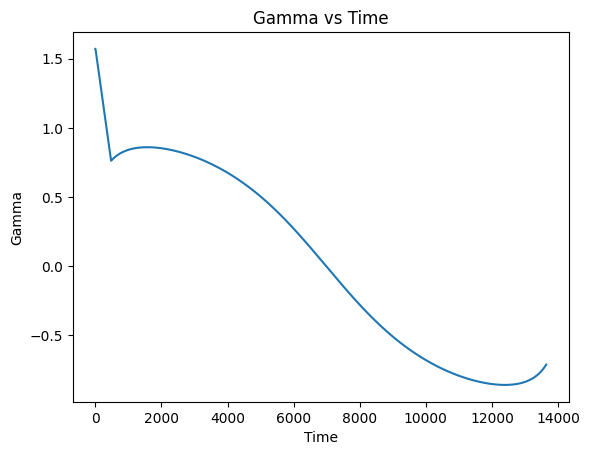

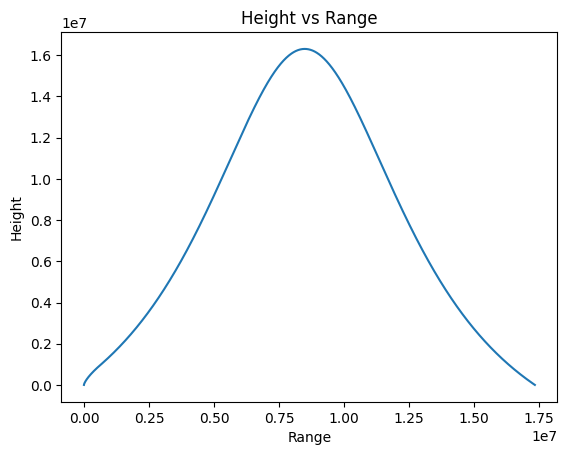

Data written to 'results/results_3.txt'

New simulation 

Isp0: 312.7568658244436


Stage 1 burnout
Velocity (km/s):  3.032338211079784
Angle (deg h):  43.650460301478454
Range (km):  89.25576829332867
Time (sec):  190.89999999999344
Final results: 
Range (km):  1245.9277561727315
Apogee (km):  391.7833115442242
Time to target (sec):  753.8000000001028




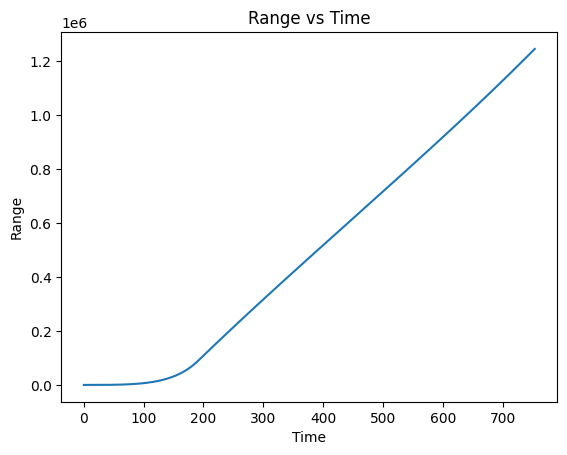

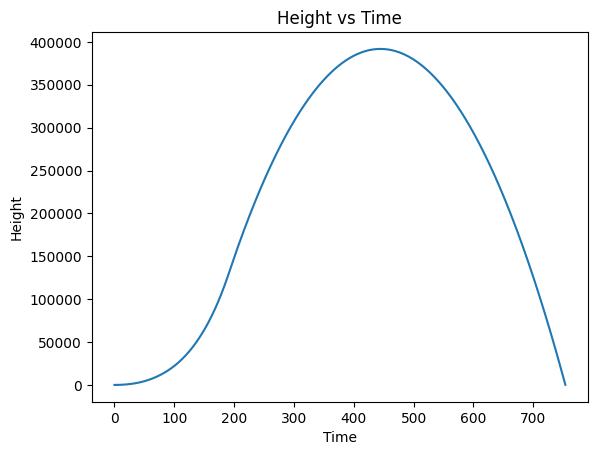

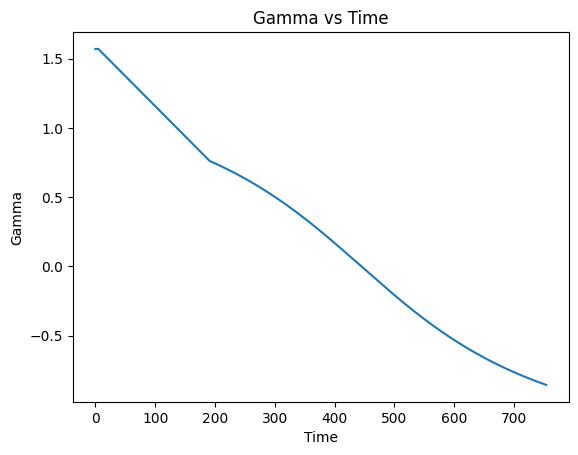

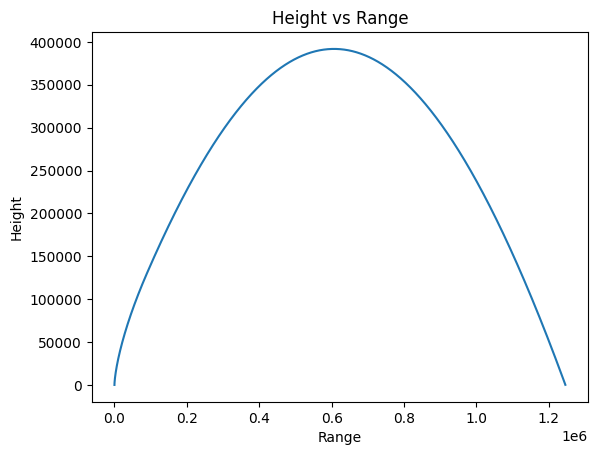

Data written to 'results/results_4.txt'


In [20]:
# Get true points (to build model)
wirte_output_txt = True

m1_design = RandomDesign(m1_space)
m1_x = m1_design.get_samples(5)
m1_y = run_missile_sim(m1_x)

In [21]:
# Build model
m1_var_kernel = (100)**2 
m1_lengthscale = 100 # 1
m1_var_linear_kernel = (100)**2 
# In catapult: RBF kernel is set to 150^2 because that’s roughly the square of the range of the catapult
m1_var_noise = 1e-5 # small value
# In catapult: 1e-5

#kern = GPy.kern.RBF(input_dim=1, lengthscale=100, variance =var_kernel )  # , lengthscale=0.08, variance=20
# kern = GPy.kern.Matern32(input_dim=1)
# kern = GPy.kern.Linear(input_dim=1)
m1_kern = GPy.kern.RBF(input_dim=1, lengthscale=m1_lengthscale ) + \
    GPy.kern.Linear(input_dim=1)

m1_model_gpy = GPRegression(m1_x,m1_y, kernel=m1_kern)
m1_model_gpy.kern.variance =  m1_var_kernel 
m1_model_gpy.likelihood.variance.fix(m1_var_noise)  

# Add constraints ?
# Add priors ?
# Change Kernel
# Change variances values

display(m1_model_gpy)



In [22]:
# Fit emulator
m1_model_emukit = GPyModelWrapper(m1_model_gpy)
m1_model_emukit.optimize() # Optimize model hyperparameters



 /Users/ilariasartori/opt/anaconda3/envs/mlphysical/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


In [23]:
display(m1_model_gpy)

In [24]:
# Get true points corresponding to param_1_x_plot (for plot)
wirte_output_txt = False

nr_points_plot = 301
m1_param_1_x_plot = np.linspace(m1_space.parameters[0].min, m1_space.parameters[0].max, nr_points_plot)[:, None]
m1_param_1_y_plot = run_missile_sim(m1_param_1_x_plot)




New simulation 

Isp0: 100.0


Stage 1 burnout
Velocity (km/s):  0.7997108219148806
Angle (deg h):  43.66690727250592
Range (km):  8.174779393074425
Time (sec):  61.0000000000006
Final results: 
Range (km):  84.94191839125949
Apogee (km):  28.119208222477383
Time to target (sec):  194.29999999999325



New simulation 

Isp0: 102.33333333333333


Stage 1 burnout
Velocity (km/s):  0.8221474843630412
Angle (deg h):  43.63686074140344
Range (km):  8.606845607579324
Time (sec):  62.50000000000062
Final results: 
Range (km):  89.67962533097281
Apogee (km):  29.62353712165415
Time to target (sec):  199.39999999999296



New simulation 

Isp0: 104.66666666666667


Stage 1 burnout
Velocity (km/s):  0.8407868820214182
Angle (deg h):  43.65587822679295
Range (km):  8.989919773699633
Time (sec):  63.90000000000064
Final results: 
Range (km):  93.79340960687088
Apogee (km):  30.9819776148128
Time to target (sec):  203.9999999999927



New simulation 

Isp0: 107.0


Stage 1 burnout
Velocity (km/s):

Stage 1 burnout
Velocity (km/s):  1.4352907914639021
Angle (deg h):  43.65523359048966
Range (km):  23.60015183304231
Time (sec):  102.29999999999846
Final results: 
Range (km):  270.23923728100175
Apogee (km):  86.8606281475925
Time to target (sec):  343.20000000000954



New simulation 

Isp0: 170.0


Stage 1 burnout
Velocity (km/s):  1.4624711011219182
Angle (deg h):  43.63974530348279
Range (km):  24.3763779610001
Time (sec):  103.79999999999838
Final results: 
Range (km):  280.4161305242348
Apogee (km):  89.97205934164992
Time to target (sec):  349.3000000000109



New simulation 

Isp0: 172.33333333333334


Stage 1 burnout
Velocity (km/s):  1.4849463257470583
Angle (deg h):  43.650977597258006
Range (km):  25.05949100306985
Time (sec):  105.1999999999983
Final results: 
Range (km):  289.0992049613216
Apogee (km):  92.73029179530126
Time to target (sec):  354.70000000001215



New simulation 

Isp0: 174.66666666666669


Stage 1 burnout
Velocity (km/s):  1.5074434572238105
Angle (d

Final results: 
Range (km):  562.5002788289032
Apogee (km):  178.14895791623573
Time to target (sec):  495.6000000000442



New simulation 

Isp0: 230.66666666666669


Stage 1 burnout
Velocity (km/s):  2.0894816836473877
Angle (deg h):  43.65067991160453
Range (km):  46.432487006725395
Time (sec):  140.7999999999963
Final results: 
Range (km):  575.7007233158929
Apogee (km):  182.35648620378268
Time to target (sec):  501.60000000004555



New simulation 

Isp0: 233.0


Stage 1 burnout
Velocity (km/s):  2.1132936193553893
Angle (deg h):  43.65877532555872
Range (km):  47.400600801338456
Time (sec):  142.1999999999962
Final results: 
Range (km):  589.2125025456945
Apogee (km):  186.63192182300722
Time to target (sec):  507.70000000004694



New simulation 

Isp0: 235.33333333333334


Stage 1 burnout
Velocity (km/s):  2.137183846569177
Angle (deg h):  43.666705080087155
Range (km):  48.37965792028906
Time (sec):  143.59999999999613
Final results: 
Range (km):  602.8833944637412
Apogee (km

Final results: 
Range (km):  1031.8174168236499
Apogee (km):  324.75272827810176
Time to target (sec):  680.6000000000862



New simulation 

Isp0: 293.6666666666667


Stage 1 burnout
Velocity (km/s):  2.7989599370438754
Angle (deg h):  43.66352177516107
Range (km):  77.7716545224234
Time (sec):  179.1999999999941
Final results: 
Range (km):  1052.536395713445
Apogee (km):  331.3293832010874
Time to target (sec):  688.0000000000879



New simulation 

Isp0: 296.0


Stage 1 burnout
Velocity (km/s):  2.8255189950885398
Angle (deg h):  43.65545191748038
Range (km):  79.06608150601154
Time (sec):  180.59999999999403
Final results: 
Range (km):  1073.719990218992
Apogee (km):  337.898114906406
Time to target (sec):  695.4000000000896



New simulation 

Isp0: 298.33333333333337


Stage 1 burnout
Velocity (km/s):  2.857652209636227
Angle (deg h):  43.649734404761034
Range (km):  80.57565246302613
Time (sec):  182.09999999999394
Final results: 
Range (km):  1099.3377276886704
Apogee (km):  34

Final results: 
Range (km):  1776.097930131204
Apogee (km):  560.508047766036
Time to target (sec):  921.800000000141



New simulation 

Isp0: 359.0


Stage 1 burnout
Velocity (km/s):  3.6008956948162747
Angle (deg h):  43.655343022389374
Range (km):  120.53153723833168
Time (sec):  219.09999999999184
Final results: 
Range (km):  1806.2611271310657
Apogee (km):  570.4017280398941
Time to target (sec):  931.1000000001432



New simulation 

Isp0: 361.33333333333337


Stage 1 burnout
Velocity (km/s):  3.6283188829046646
Angle (deg h):  43.66047997798077
Range (km):  122.19054909218048
Time (sec):  220.49999999999176
Final results: 
Range (km):  1836.8224213087876
Apogee (km):  580.4195257501129
Time to target (sec):  940.5000000001453



New simulation 

Isp0: 363.6666666666667


Stage 1 burnout
Velocity (km/s):  3.655721332533231
Angle (deg h):  43.652395461425826
Range (km):  123.86193460792873
Time (sec):  221.89999999999168
Final results: 
Range (km):  1867.998990744323
Apogee (km):

Final results: 
Range (km):  2805.629940993813
Apogee (km):  903.5408692783352
Time to target (sec):  1225.9999999999804



New simulation 

Isp0: 424.33333333333337


Stage 1 burnout
Velocity (km/s):  4.403277788560145
Angle (deg h):  43.64974086639768
Range (km):  173.7090903083748
Time (sec):  258.9999999999904
Final results: 
Range (km):  2855.20021050575
Apogee (km):  920.3588183950789
Time to target (sec):  1240.1999999999675



New simulation 

Isp0: 426.6666666666667


Stage 1 burnout
Velocity (km/s):  4.430400776565268
Angle (deg h):  43.65410838163965
Range (km):  175.71710503443555
Time (sec):  260.3999999999907
Final results: 
Range (km):  2896.770909079095
Apogee (km):  934.9192229657586
Time to target (sec):  1252.3999999999564



New simulation 

Isp0: 429.0


Stage 1 burnout
Velocity (km/s):  4.457498071486158
Angle (deg h):  43.658427511217575
Range (km):  177.73634854084642
Time (sec):  261.79999999999103
Final results: 
Range (km):  2938.68150212388
Apogee (km):  949

Final results: 
Range (km):  4213.6210060546055
Apogee (km):  1412.8583681383823
Time to target (sec):  1639.2999999996046



New simulation 

Isp0: 489.6666666666667


Stage 1 burnout
Velocity (km/s):  5.196196864984662
Angle (deg h):  43.6614755539435
Range (km):  236.41651867297347
Time (sec):  298.79999999999944
Final results: 
Range (km):  4269.220751799408
Apogee (km):  1434.378502844743
Time to target (sec):  1656.1999999995892



New simulation 

Isp0: 492.0


Stage 1 burnout
Velocity (km/s):  5.223324181400515
Angle (deg h):  43.653278175683326
Range (km):  238.75488640051833
Time (sec):  300.19999999999976
Final results: 
Range (km):  4325.799400104258
Apogee (km):  1455.825990063402
Time to target (sec):  1673.0999999995738



New simulation 

Isp0: 494.33333333333337


Stage 1 burnout
Velocity (km/s):  5.256131062975095
Angle (deg h):  43.65327367472645
Range (km):  241.4638633039229
Time (sec):  301.7000000000001
Final results: 
Range (km):  4394.108746984363
Apogee (km): 

Stage 1 burnout
Velocity (km/s):  5.969649197522288
Angle (deg h):  43.653262906719554
Range (km):  306.2104157921432
Time (sec):  337.3000000000082
Final results: 
Range (km):  6116.825272753538
Apogee (km):  2200.224244235416
Time to target (sec):  2247.0999999990518



New simulation 

Isp0: 555.0


Stage 1 burnout
Velocity (km/s):  5.996896535791876
Angle (deg h):  43.656595507113046
Range (km):  308.8541861799963
Time (sec):  338.7000000000085
Final results: 
Range (km):  6191.621535634634
Apogee (km):  2234.4796859074486
Time to target (sec):  2273.099999999028



New simulation 

Isp0: 557.3333333333334


Stage 1 burnout
Velocity (km/s):  6.0241322104527315
Angle (deg h):  43.65989985825571
Range (km):  311.5075115416291
Time (sec):  340.10000000000883
Final results: 
Range (km):  6267.021518376941
Apogee (km):  2269.3090252924835
Time to target (sec):  2299.499999999004



New simulation 

Isp0: 559.6666666666667


Stage 1 burnout
Velocity (km/s):  6.051392334158504
Angle (deg 

Final results: 
Range (km):  8431.29333535501
Apogee (km):  3384.6953098717186
Time to target (sec):  3141.999999998238



New simulation 

Isp0: 615.6666666666667


Stage 1 burnout
Velocity (km/s):  6.742004557797099
Angle (deg h):  43.6593124393506
Range (km):  383.9361619575346
Time (sec):  375.7000000000169
Final results: 
Range (km):  8527.370730766654
Apogee (km):  3441.4521414297596
Time to target (sec):  3184.699999998199



New simulation 

Isp0: 618.0


Stage 1 burnout
Velocity (km/s):  6.769448803269196
Angle (deg h):  43.65083920849818
Range (km):  386.8689329150059
Time (sec):  377.10000000001725
Final results: 
Range (km):  8625.328886438181
Apogee (km):  3498.5900094789636
Time to target (sec):  3227.8999999981597



New simulation 

Isp0: 620.3333333333334


Stage 1 burnout
Velocity (km/s):  6.802636357006108
Angle (deg h):  43.6528241468581
Range (km):  390.2627146577257
Time (sec):  378.6000000000176
Final results: 
Range (km):  8742.27748219676
Apogee (km):  3568.927

Final results: 
Range (km):  11438.77059558951
Apogee (km):  5555.08958297091
Time to target (sec):  4783.599999999871



New simulation 

Isp0: 678.6666666666667


Stage 1 burnout
Velocity (km/s):  7.52060877970445
Angle (deg h):  43.652928989941145
Range (km):  469.53491284868477
Time (sec):  414.10000000002566
Final results: 
Range (km):  11557.69004762798
Apogee (km):  5660.666455370574
Time to target (sec):  4864.5000000001655



New simulation 

Isp0: 681.0


Stage 1 burnout
Velocity (km/s):  7.5540549892304085
Angle (deg h):  43.6556712842263
Range (km):  473.2327991338899
Time (sec):  415.600000000026
Final results: 
Range (km):  11697.476034395966
Apogee (km):  5790.913442909934
Time to target (sec):  4963.800000000527



New simulation 

Isp0: 683.3333333333334


Stage 1 burnout
Velocity (km/s):  7.5817561332566195
Angle (deg h):  43.658366207940595
Range (km):  476.45017221337207
Time (sec):  417.0000000000263
Final results: 
Range (km):  11815.462282880037
Apogee (km):  590

Final results: 
Range (km):  14938.316105207963
Apogee (km):  10028.478632801825
Time to target (sec):  8293.200000012639



New simulation 

Isp0: 741.6666666666667


Stage 1 burnout
Velocity (km/s):  8.312347601815297
Angle (deg h):  43.658088666416944
Range (km):  563.0978493362005
Time (sec):  452.6000000000344
Final results: 
Range (km):  15065.153631944484
Apogee (km):  10266.187063542404
Time to target (sec):  8486.00000001334



New simulation 

Isp0: 744.0


Stage 1 burnout
Velocity (km/s):  8.340337088435794
Angle (deg h):  43.66055523491485
Range (km):  566.5647490351604
Time (sec):  454.00000000003473
Final results: 
Range (km):  15191.910265046341
Apogee (km):  10512.005128801015
Time to target (sec):  8686.100000014068



New simulation 

Isp0: 746.3333333333334


Stage 1 burnout
Velocity (km/s):  8.368321787909588
Angle (deg h):  43.65168834572543
Range (km):  570.0389765894906
Time (sec):  455.40000000003505
Final results: 
Range (km):  15322.650464282442
Apogee (km):  

In [25]:
# Get model prediction on param_1_x_plot
m1_mu_plot, m1_var_plot = m1_model_emukit.predict(m1_param_1_x_plot)



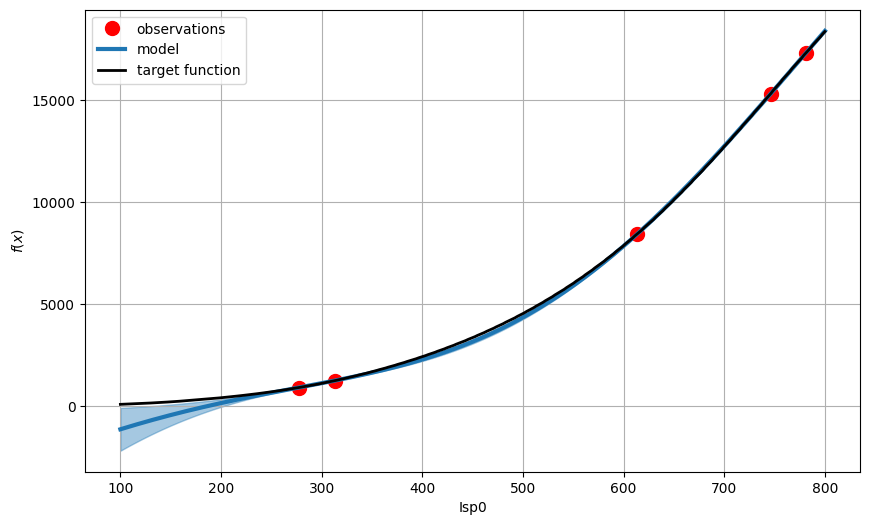

In [26]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
helper_plot_emulator_errorbars(x_plot=m1_param_1_x_plot, y_plot=m1_param_1_y_plot, 
                               mu_plot=m1_mu_plot, var_plot=m1_var_plot, 
                               model_emukit=m1_model_emukit)

# 1. Two params

In [27]:
m2_param_1 = 'fuelmass'
m2_domain_param_1 = basic_param_spaces[m2_param_1] # [500, 6000] # [5000,15000]
m2_param_2 = 'Isp0'
m2_domain_param_2 = basic_param_spaces[m2_param_2] # [200, 300] # [224, 228]

m2_space = ParameterSpace(
          [ContinuousParameter(m2_param_1, *m2_domain_param_1), 
           ContinuousParameter(m2_param_2, *m2_domain_param_2),
#            ContinuousParameter(param_3, *domain_param_3),
#            ContinuousParameter(param_4, *domain_param_4)
          ])

custom_param_names = [m2_param_1, m2_param_2]

In [28]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION (Re-run since custom_param_names has changed)
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
                
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y


## 1. Experimental design

Experimental design addresses the problem of how to collect data points (experiments) to better control certain sources of variance of a model.

In experimental design the goal is to decide at which locations of the input space we should evaluate a function of interest. In some contexts it is also known as active learning, for instance in image classification problems in which more labels need to be collected.

The are two main ways of doing experimental design.

1. Model-free designs: These designs define rules to spread the experiments as much as possible across the input domain. Drawing points at random or in a grid are the most naive way of doing so. Other more elaborate approaches are low discrepancy sequences that try to induce some negative correlation in the selected points to spread them evenly. Some examples are Latin hyper-cube sampling and Sobol sequences.

2. Model-based designs: In these designs a feedback loop is used between some ‘optimal’ statistical criterion to collect points and a model. In general, the criterion aims to reduce some type of variance in the model. The type of optimality refers to which type of uncertainty that is reduced. For instance, a D-optimal design aims to maximize the differential Shannon information content of the model parameter estimates; an I-optimal design seeks to minimize the average prediction variance over the entire design space. 

Gaussian processes have a long tradition of being the ‘model of choice’ for designing experiments.

### Use model-free experimental design to start
 (RandomDesign or Latin Design)


New simulation 

fuelmass: 5353.529258601382
Isp0: 783.6147909204918


Stage 1 burnout
Velocity (km/s):  8.700712889613296
Angle (deg h):  43.65209234381408
Range (km):  603.0206544115204
Time (sec):  457.10000000003544
Final results: 
Range (km):  16793.988170739933
Apogee (km):  14488.385586611115
Time to target (sec):  12022.200000026205




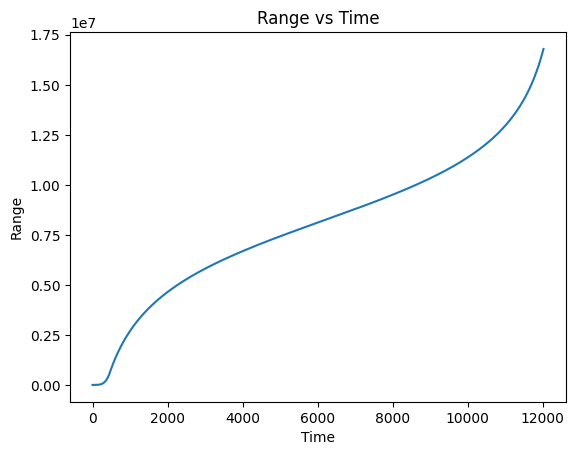

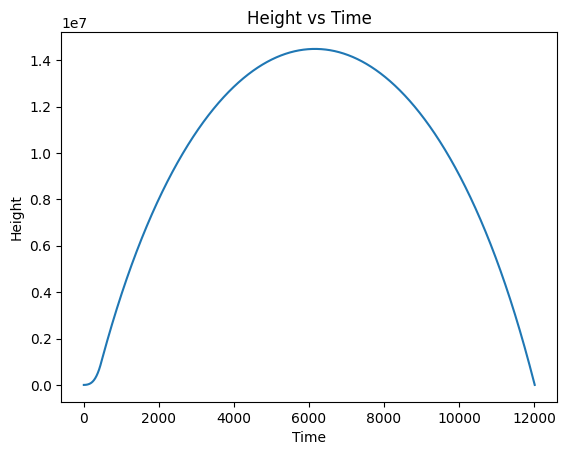

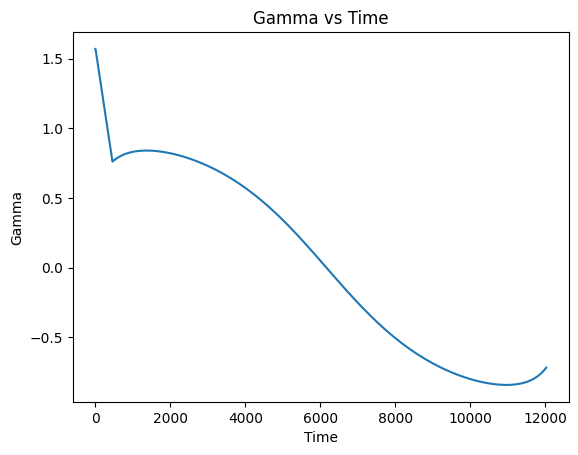

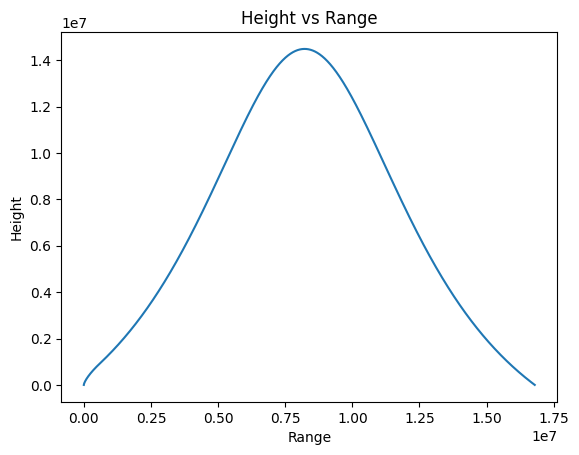

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 1525.3118574174805
Isp0: 492.69311082722936


Stage 1 burnout
Velocity (km/s):  2.2932851213980907
Angle (deg h):  43.687392337079245
Range (km):  38.5269330126835
Time (sec):  81.89999999999962
Final results: 
Range (km):  664.5156693800968
Apogee (km):  202.95312648713534
Time to target (sec):  472.800000000039




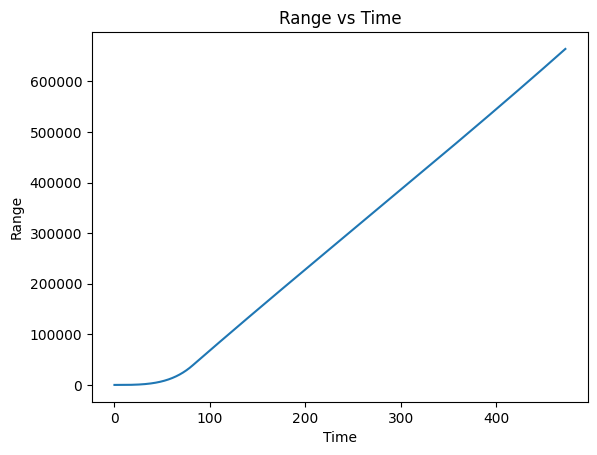

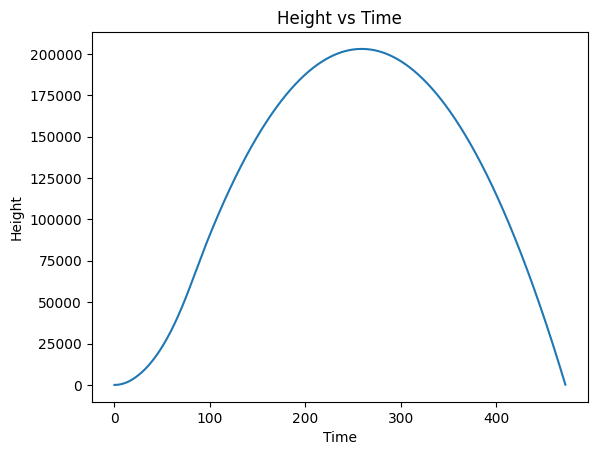

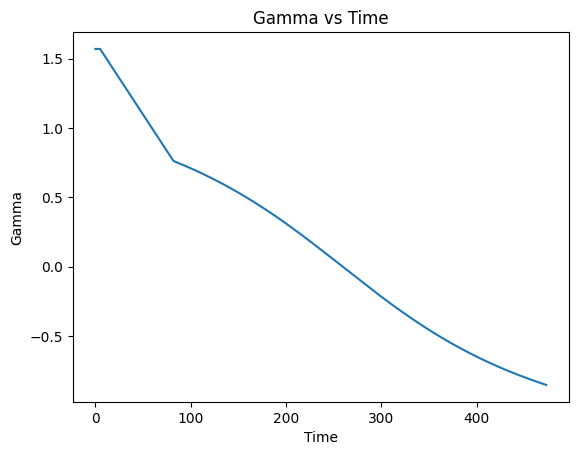

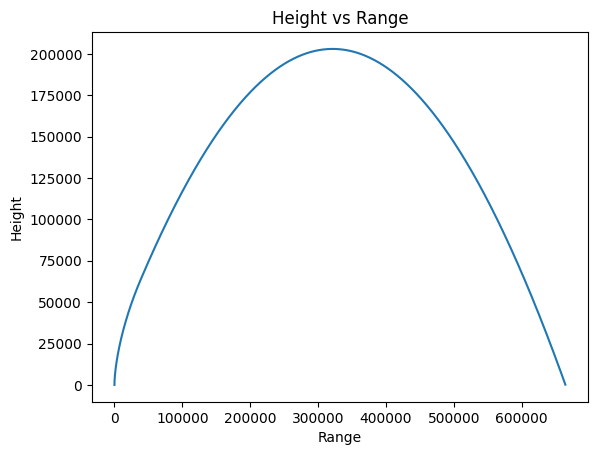

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 1671.5141863439178
Isp0: 305.57695893820164


Stage 1 burnout
Velocity (km/s):  1.4046435568159905
Angle (deg h):  43.6740982783881
Range (km):  16.21091132803424
Time (sec):  55.70000000000052
Final results: 
Range (km):  247.06002512806415
Apogee (km):  77.06025772680877
Time to target (sec):  285.8999999999965




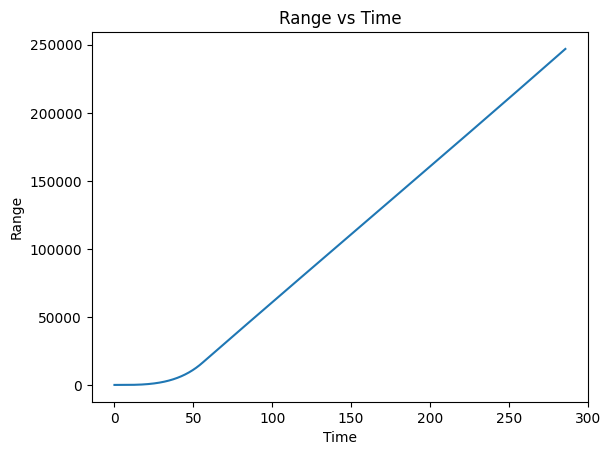

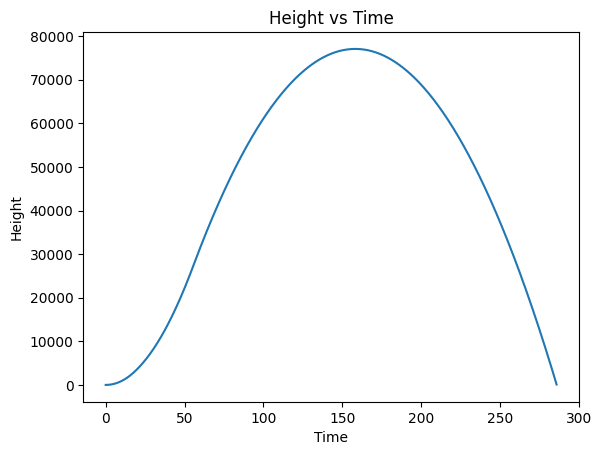

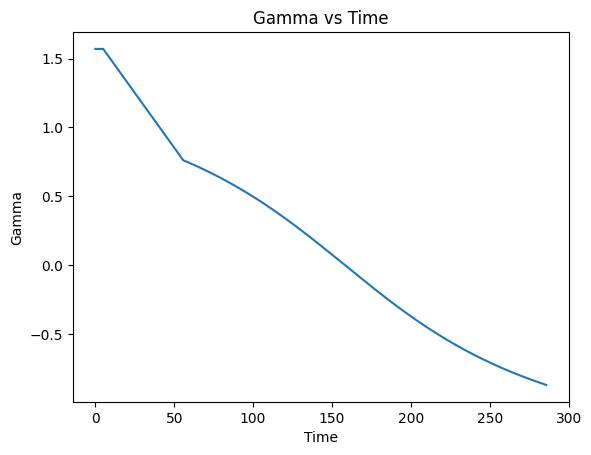

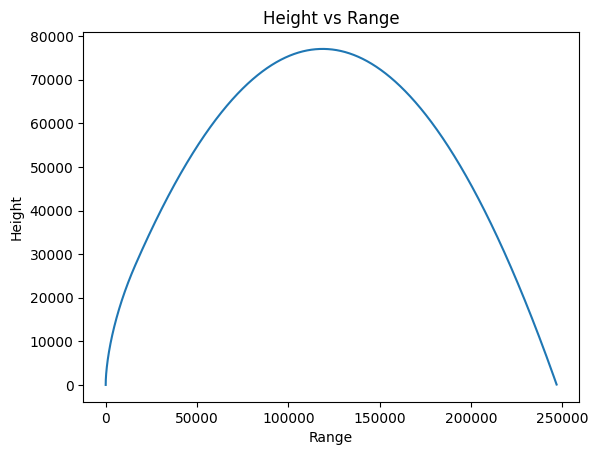

Data written to 'results/results_2.txt'

New simulation 

fuelmass: 1439.422957255716
Isp0: 657.482809234459


Stage 1 burnout
Velocity (km/s):  3.092557921765926
Angle (deg h):  43.65064951777508
Range (km):  65.21990091823204
Time (sec):  103.19999999999841
Final results: 
Range (km):  1242.8248568370116
Apogee (km):  378.24370067638074
Time to target (sec):  665.1000000000827




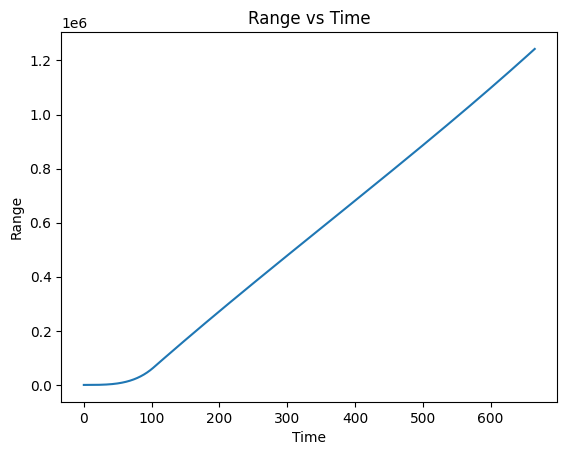

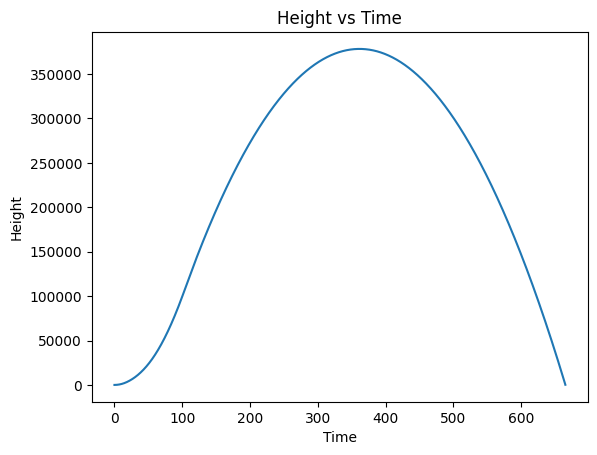

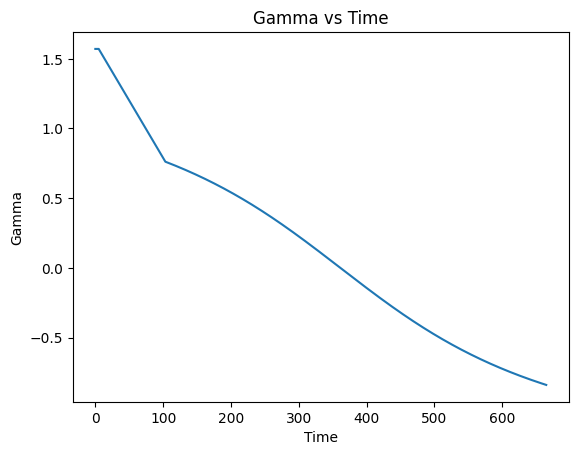

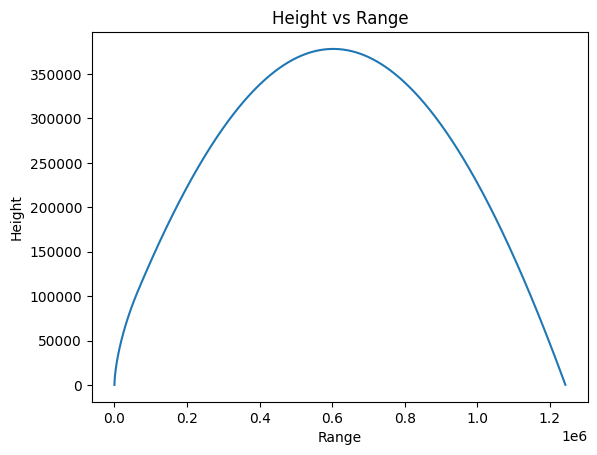

Data written to 'results/results_3.txt'

New simulation 

fuelmass: 5273.970550859417
Isp0: 645.267036700889


Stage 1 burnout
Velocity (km/s):  6.958438854518642
Angle (deg h):  43.65273074532996
Range (km):  399.6421362455464
Time (sec):  370.8000000000158
Final results: 
Range (km):  9290.790019391296
Apogee (km):  3913.5901633947688
Time to target (sec):  3526.3999999978882




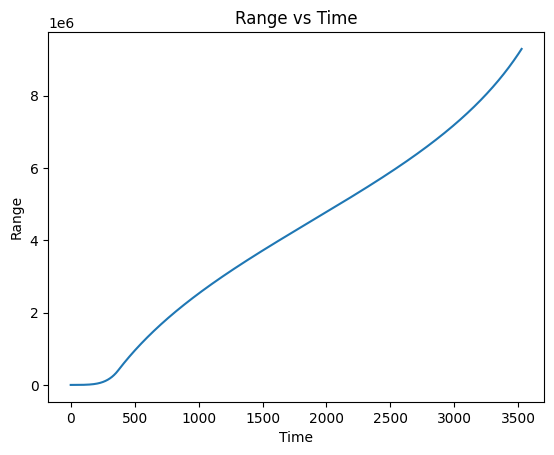

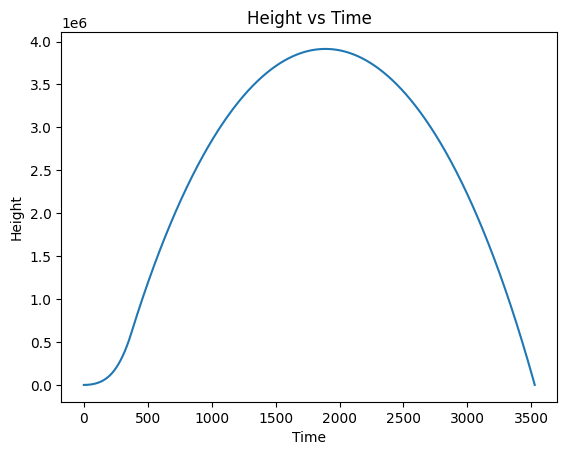

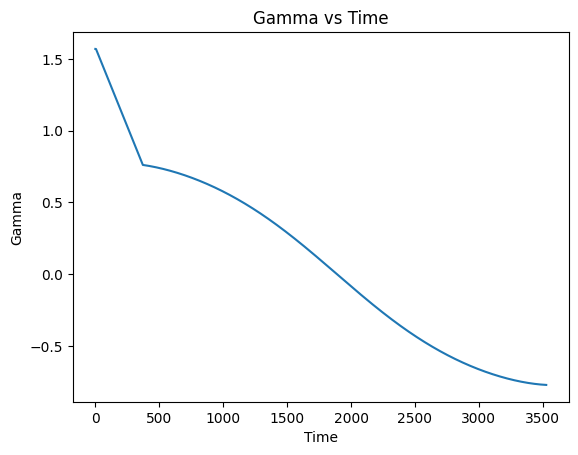

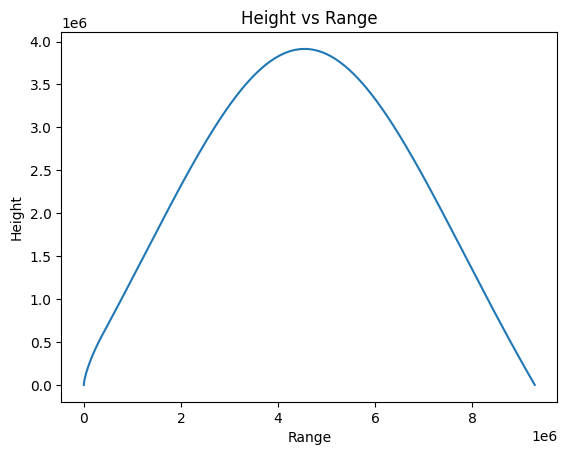

Data written to 'results/results_4.txt'


In [29]:
wirte_output_txt = True


# from emukit.core.initial_designs.latin_design import LatinDesign
# design = LatinDesign(parameter_space) 

m2_design = RandomDesign(m2_space)
m2_x = m2_design.get_samples(5)
m2_y = run_missile_sim(m2_x)

In [30]:
# Build model
m2_var_kernel = (100)**2 
m2_lengthscale = 100 # 1
# In catapult: RBF kernel is set to 150^2 because that’s roughly the square of the range of the catapult
m2_var_noise = 1e-5 # small value
# In catapult: 1e-5

#kern = GPy.kern.RBF(input_dim=2, lengthscale=lengthscale, variance =var_kernel)  # , lengthscale=0.08, variance=20
# kern = GPy.kern.Matern32(input_dim=1)
# kern = GPy.kern.Linear(input_dim=1)
m2_kern = GPy.kern.RBF(input_dim=2, lengthscale=m2_lengthscale ) + \
    GPy.kern.Linear(input_dim=2)

m2_model_gpy = GPRegression(m2_x,m2_y, kernel=m2_kern)
m2_model_gpy.kern.variance =  m2_var_kernel 
m2_model_gpy.likelihood.variance.fix(m2_var_noise)  

# Add constraints ?
# Add priors ?
# Change Kernel
# Change variances values

display(m2_model_gpy)




In [31]:
m2_model_emukit = GPyModelWrapper(m2_model_gpy)
m2_model_emukit.optimize()

 /Users/ilariasartori/opt/anaconda3/envs/mlphysical/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /Users/ilariasartori/opt/anaconda3/envs/mlphysical/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


In [32]:
display(m2_model_gpy)

In [33]:
# Create data for plot
wirte_output_txt = False
nr_points_plot = 101
m2_param_1_x_plot = np.linspace(m2_space.parameters[0].min, m2_space.parameters[0].max, nr_points_plot)[:, None]
m2_param_2_x_plot = np.linspace(m2_space.parameters[1].min, m2_space.parameters[1].max, nr_points_plot)[:, None]
m2_x_plot_mesh, m2_y_plot_mesh = np.meshgrid(m2_param_1_x_plot, m2_param_2_x_plot)
m2_x_plot = np.array([m2_x_plot_mesh, m2_y_plot_mesh]).T.reshape(-1,2)

if run_grid_simulation:
    m2_y_plot = run_missile_sim(m2_x_plot) # TAKES LONG TIME
    m2_Z = m2_y_plot.reshape(m2_x_plot_mesh.shape)



In [34]:
# Compute current prediction
m2_mu_plot_grid_pred1, var_plot_grid_pred1 = m2_model_emukit.predict(m2_x_plot)
m2_mu_plot_pred1 = m2_mu_plot_grid_pred1.reshape(m2_x_plot_mesh.shape)
m2_var_plot_pred1 = var_plot_grid_pred1.reshape(m2_x_plot_mesh.shape)




In [35]:
if run_grid_simulation:
    # 3D Plot
    add_bands = False


    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # True surface
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_Z, 
                           alpha = .5, 
                           label='target function',
                           color='black'
                          )
    # Mean predicted
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1, 
                           alpha = .5, 
                           label='model', # Mean
                           color='royalblue'
                          )
    # True points observed
    ax.scatter(m2_x[:,0], m2_x[:,1], m2_y, marker='o', color='red')

    if add_bands:
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1-2*m2_var_plot_pred1, 
                               alpha = .5, 
                               label='model_ci_lb', # Confidence band lower bound
                               color='lightskyblue'
                              )
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1+2*m2_var_plot_pred1, 
                               alpha = .5, 
                               label='model_ci_ub', # Confidence band upper bound
                               color='lightskyblue' 
                              )
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    ax.set_zlabel('Target function')
    plt.tight_layout()



In [36]:
if run_grid_simulation:
    ## Heatmaps
    extents = [m2_space.parameters[0].min, m2_space.parameters[0].max, 
               m2_space.parameters[1].min, m2_space.parameters[1].max]

    # True values
    fig, ax = plt.subplots()
    im = ax.imshow(m2_Z, extent=extents, aspect='auto')
    ax.set_title('Target function')
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    fig.colorbar(im, ax=ax)
    fig.show()

    # Model
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred1, extent=extents, aspect='auto')
    ax.set_title('Model (mean)')
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    fig.colorbar(im, ax=ax)
    fig.show()


    # Difference
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred1-m2_Z, extent=extents, aspect='auto')
    ax.set_title('Difference between model and target function')
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    ax.plot(m2_x[:,0], m2_x[:,1], 'ro')
    fig.colorbar(im, ax=ax)
    fig.show()




### Use the model created for model-based experiment design
use the model to decide which are the best points to collect using some data collection criteria (that we call acquisition).

In [37]:
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance


In [38]:
# help(ExperimentalDesignLoop)

 It is known that when using Gaussian processes, selecting points of maximum variance is equivalent to maximizing the mutual information between the model and the new set of points so using ModelVariance is a simple but mathematically grounded approach.
 
 Actually in this example we use IVR

In [39]:
m2_2_model_emukit = m2_model_emukit

In [40]:
wirte_output_txt = False

integrated_variance = IntegratedVarianceReduction(space=m2_space,
                                                  model=m2_model_emukit)
m2_ed = ExperimentalDesignLoop(space=m2_space, 
                            model=m2_2_model_emukit, 
                            acquisition = integrated_variance,
                            batch_size = 1) 
# bach size is set to one in this example as we’ll collect evaluations 
# sequentially but parallel evaluations are allowed
m2_ed.run_loop(user_function=run_missile_sim, stopping_condition=10)


 /Users/ilariasartori/opt/anaconda3/envs/mlphysical/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



New simulation 

fuelmass: 5909.931519240411
Isp0: 121.63867043207736


Stage 1 burnout
Velocity (km/s):  1.0054599359160448
Angle (deg h):  43.630851161128
Range (km):  12.781507643197926
Time (sec):  78.39999999999982
Final results: 
Range (km):  134.04092674474668
Apogee (km):  43.93621602015035
Time to target (sec):  246.1999999999903



New simulation 

fuelmass: 809.965798957202
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  2.298124746485942
Angle (deg h):  43.65451624309242
Range (km):  34.87032428873967
Time (sec):  70.60000000000026
Final results: 
Range (km):  659.2089214494292
Apogee (km):  198.7989290942407
Time to target (sec):  459.30000000003594



New simulation 

fuelmass: 5980.7949491986155
Isp0: 101.93558216025524


Stage 1 burnout
Velocity (km/s):  0.8336917637498434
Angle (deg h):  43.6253843317523
Range (km):  9.04026170378132
Time (sec):  66.5000000000005
Final results: 
Range (km):  92.51706505316163
Apogee (km):  30.531171427147466
Time to target (sec):  205

In [41]:
m2_2_model_emukit.__dict__

{'model': <GPy.models.gp_regression.GPRegression at 0x7f912a26abf0>,
 'n_restarts': 1}

In [42]:
m2_ed.__dict__

{'candidate_point_calculator': <emukit.core.loop.candidate_point_calculators.SequentialPointCalculator at 0x7f90f8152800>,
 'model_updaters': [<emukit.core.loop.model_updaters.FixedIntervalUpdater at 0x7f90f8152ad0>],
 'loop_state': <emukit.core.loop.loop_state.LoopState at 0x7f90f8152650>,
 'loop_start_event': Event([]),
 'iteration_end_event': Event([]),
 'model': <emukit.model_wrappers.gpy_model_wrappers.GPyModelWrapper at 0x7f9138ab1db0>}

In [43]:
if run_grid_simulation:
    # Compute new prediction
    m2_mu_plot_grid_pred2, var_plot_grid_pred2 = m2_2_model_emukit.predict(m2_x_plot)
    m2_mu_plot_pred2 = m2_mu_plot_grid_pred2.reshape(m2_x_plot_mesh.shape)
    m2_var_plot_pred2 = var_plot_grid_pred2.reshape(m2_x_plot_mesh.shape)




In [44]:
if run_grid_simulation:
    # 3D Plot
    add_bands = False


    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # True surface
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_Z, 
                           alpha = .5, 
                           label='target function',
                           color='black'
                          )
    # Mean predicted
    surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred2, 
                           alpha = .5, 
                           label='model', # Mean
                           color='royalblue'
                          )
    # True points observed
    ax.scatter(np.array(m2_2_model_emukit.X)[:,0], 
               np.array(m2_2_model_emukit.X)[:,1], m2_2_model_emukit.Y, marker='o', color='red')

    if add_bands:
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred2-2*m2_var_plot_pred2, 
                               alpha = .5, 
                               label='model_ci_lb', # Confidence band lower bound
                               color='lightskyblue'
                              )
        surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred2+2*m2_var_plot_pred2, 
                               alpha = .5, 
                               label='model_ci_ub', # Confidence band upper bound
                               color='lightskyblue' 
                              )
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    ax.set_zlabel('Target function')
    plt.tight_layout()




In [45]:
if run_grid_simulation:

    ## Heatmaps
    extents = [m2_space.parameters[0].min, m2_space.parameters[0].max, 
               m2_space.parameters[1].min, m2_space.parameters[1].max]

    # True values
    fig, ax = plt.subplots()
    im = ax.imshow(m2_Z, extent=extents, aspect='auto')
    ax.set_title('Target function')
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    fig.colorbar(im, ax=ax)
    fig.show()

    # Model
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred2, extent=extents, aspect='auto')
    ax.set_title('Model (mean)')
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    fig.colorbar(im, ax=ax)
    fig.show()


    # Difference
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred2-m2_Z, extent=extents, aspect='auto')
    ax.set_title('Difference between model and target function')
    ax.set_xlabel(m2_param_1)
    ax.set_ylabel(m2_param_2)
    ax.plot(np.array(m2_2_model_emukit.X)[:,0], np.array(m2_2_model_emukit.X)[:,1], 'ro')
    fig.colorbar(im, ax=ax)
    fig.show()


    # ax.plot(m2_x, m2_y, marker='o', color='red')

## 2. Maximize range

The central idea of the acquisition function is to trade off the exploration of regions where the model is uncertain and the exploitation of the model’s confidence about good areas of the input space. There are a variety of acquisition functions in Emukit. In this example the expected improvement [3], that computes in expectation how much we can improve with respect to the current best observed location.

Bayesian optimization iterates the following three steps until it achieves a predefined stopping criterion (normally using a fixed number of evaluations).

1. Find the next point to evaluate the objective by using a numerical solver to optimize the acquisition/utility.
2. Evaluate the objective in that location and add the new observation to the data set.
3. Update the model using the currently available data.


In [46]:
m3_param_1 = 'fuelmass'
m3_param_2 = 'Isp0'
m3_param_3 = 'drymass'
m3_param_4 = 'thrust0'
# m3_param_5 = 'payload'
# m3_param_6 = 'missilediam'
# I am not sure 'estrange' and 'rvdiam' can be changed freely

m3_domain_param_1 = basic_param_spaces[m3_param_1] # [500, 6000] # [5000,15000]
m3_domain_param_2 = basic_param_spaces[m3_param_2] # [200, 300] # [224, 228]
m3_domain_param_3 = basic_param_spaces[m3_param_3] 
m3_domain_param_4 = basic_param_spaces[m3_param_4] 
# m3_domain_param_5 = basic_param_spaces[m3_param_5] 
# m3_domain_param_6 = basic_param_spaces[m3_param_6] 


m3_space = ParameterSpace(
          [ContinuousParameter(m3_param_1, *m3_domain_param_1), 
           ContinuousParameter(m3_param_2, *m3_domain_param_2),
           ContinuousParameter(m3_param_3, *m3_domain_param_3), 
           ContinuousParameter(m3_param_4, *m3_domain_param_4),
#            ContinuousParameter(m3_param_5, *m3_domain_param_5), 
#            ContinuousParameter(m3_param_6, *m3_domain_param_6),
          ])
custom_param_names = [m3_param_1, m3_param_2, m3_param_3, m3_param_4, 
#                       m3_param_5, m3_param_6
                     ]
nr_custom_params = len(custom_param_names)

In [47]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION (Re-run since custom_param_names has changed)
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
                
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y



In [48]:
def neg_run_missile_sim(custom_params):
    return -run_missile_sim(custom_params)




New simulation 

fuelmass: 1567.7785771586455
Isp0: 446.4961438377249
drymass: 2200.485001030891
thrust0: 44511.81598747537


Stage 1 burnout
Velocity (km/s):  1.735369842445727
Angle (deg h):  43.74218348027684
Range (km):  5.285533605953221
Time (sec):  15.799999999999962
Final results: 
Range (km):  331.9124648718883
Apogee (km):  87.68117302383801
Time to target (sec):  280.79999999999535




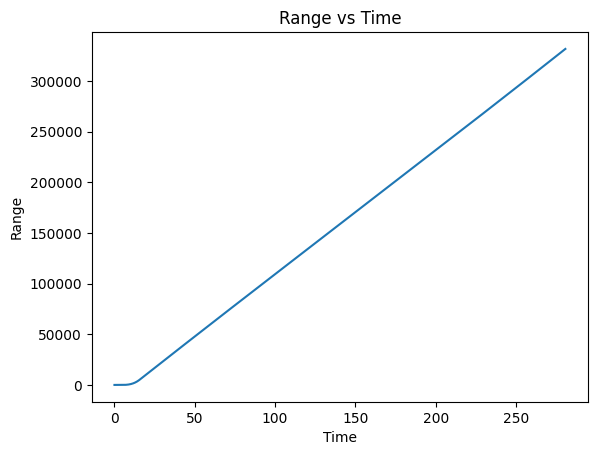

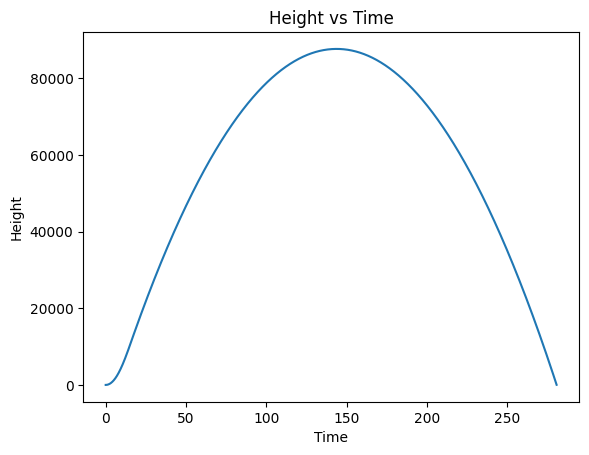

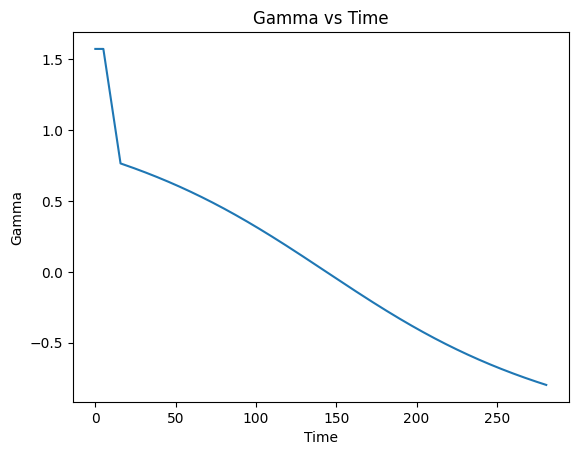

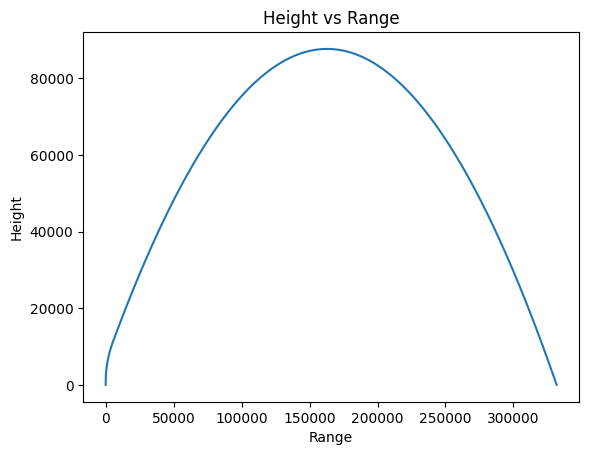

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 4092.21668854972
Isp0: 644.6513896681756
drymass: 2434.526904734772
thrust0: 16450.571901470998


Stage 1 burnout
Velocity (km/s):  4.606114907149588
Angle (deg h):  43.66407313591477
Range (km):  141.25060568757718
Time (sec):  160.39999999999517
Final results: 
Range (km):  3059.5261782162615
Apogee (km):  969.3223446100648
Time to target (sec):  1193.9000000000096




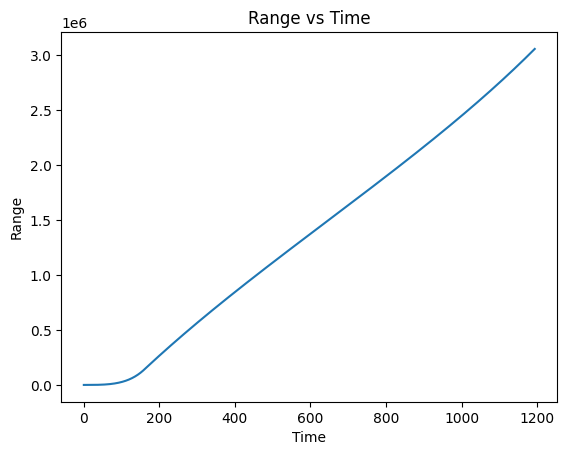

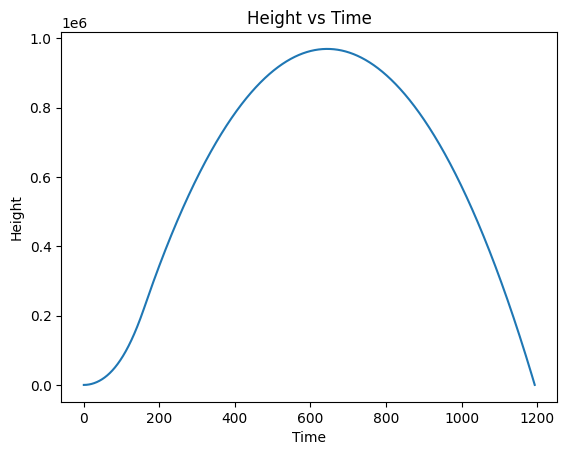

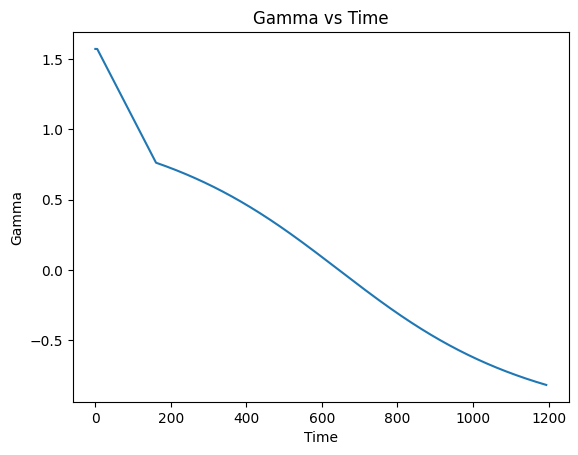

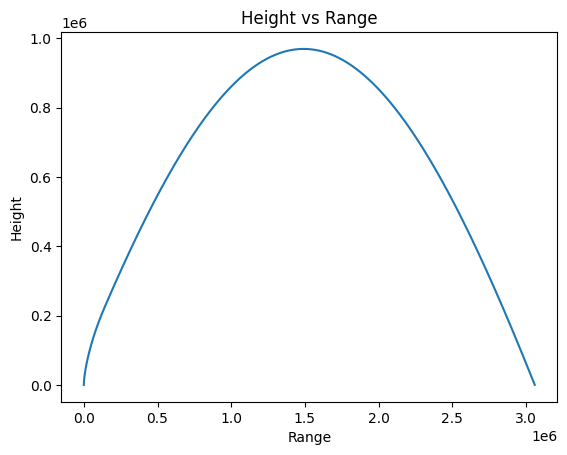

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 2846.8170465905155
Isp0: 102.50602364583776
drymass: 1003.0990801252453
thrust0: 45400.0926790364


Stage 1 burnout
Velocity (km/s):  0.9745657813181335
Angle (deg h):  44.506343595063846
Range (km):  0.509879802872563
Time (sec):  6.499999999999994
Final results: 
Range (km):  100.61993097945205
Apogee (km):  26.58049245825145
Time to target (sec):  151.2999999999957




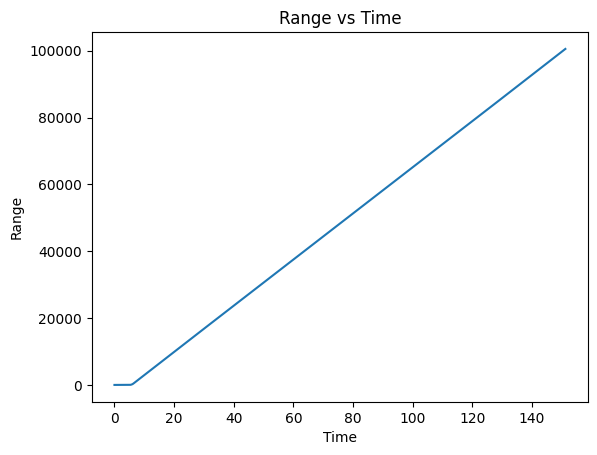

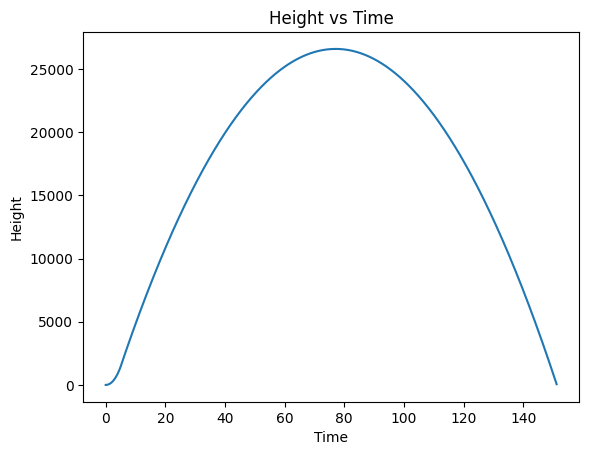

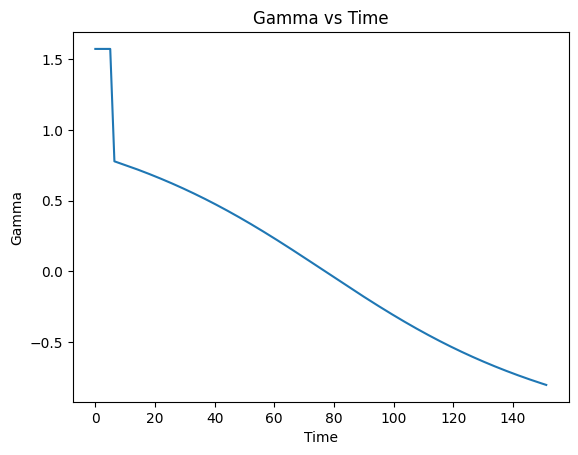

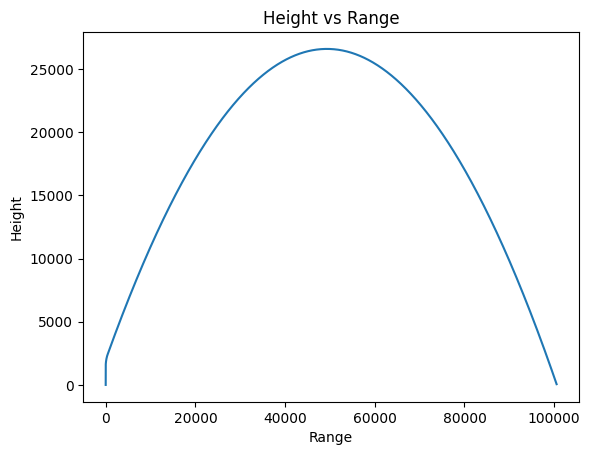

Data written to 'results/results_2.txt'

New simulation 

fuelmass: 1741.8014131578173
Isp0: 765.7162706760083
drymass: 2392.8847170645267
thrust0: 21052.11030693521


Stage 1 burnout
Velocity (km/s):  2.9504185299964285
Angle (deg h):  43.681723118944944
Range (km):  40.24529364681533
Time (sec):  63.40000000000063
Final results: 
Range (km):  1072.8672644094117
Apogee (km):  310.20223830575793
Time to target (sec):  575.3000000000623




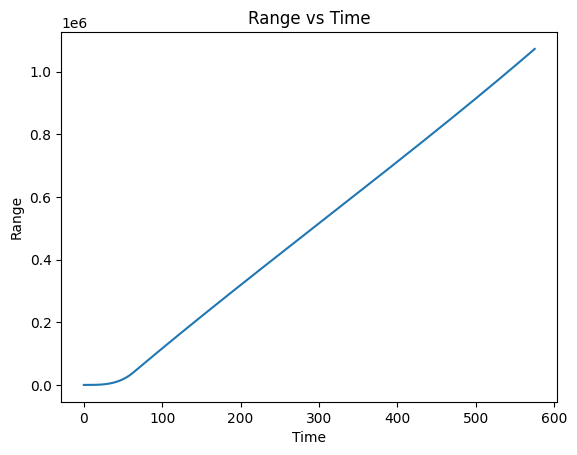

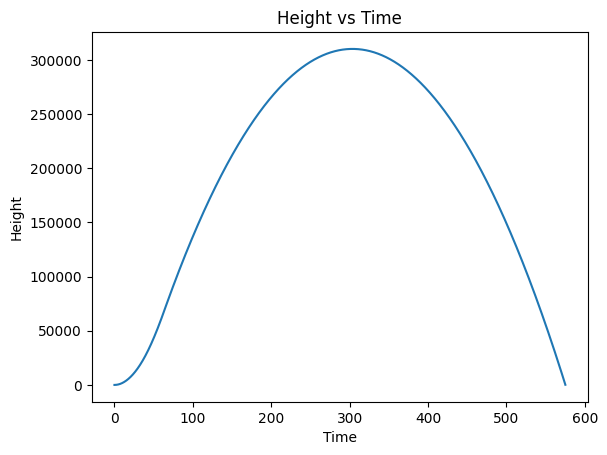

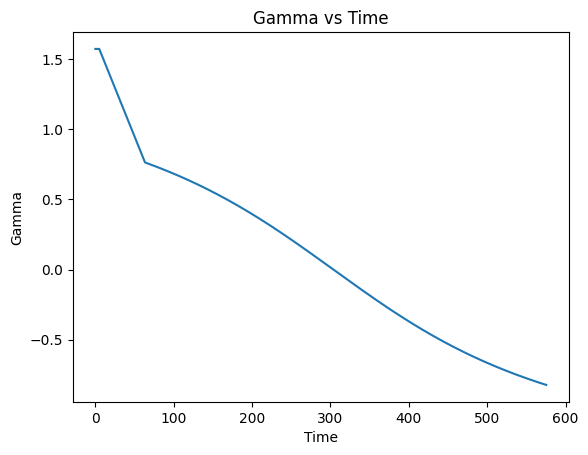

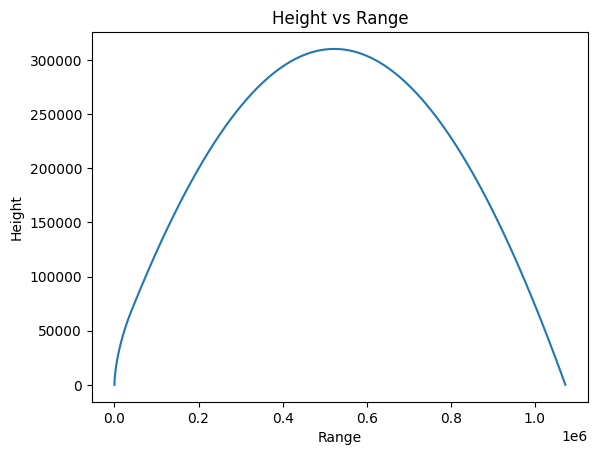

Data written to 'results/results_3.txt'

New simulation 

fuelmass: 3652.1661072420616
Isp0: 348.5240960928687
drymass: 1230.4065563219028
thrust0: 60811.58348136823


Stage 1 burnout
Velocity (km/s):  3.499330138293409
Angle (deg h):  43.732649052439946
Range (km):  13.583097644663747
Time (sec):  21.000000000000032
Final results: 
Range (km):  1430.045788302451
Apogee (km):  377.966937360642
Time to target (sec):  624.4000000000734




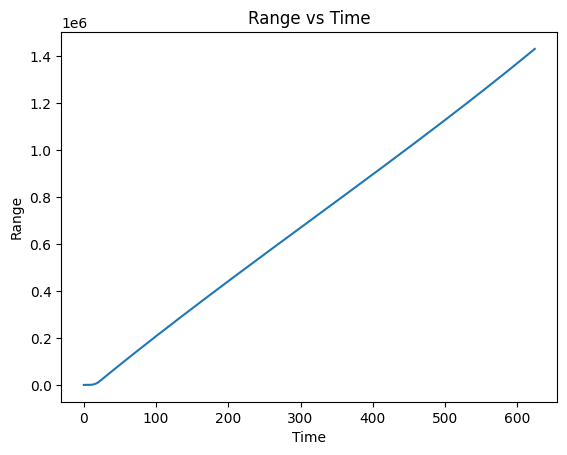

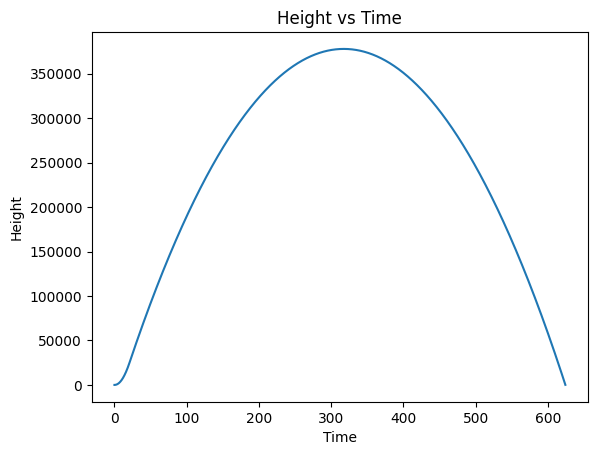

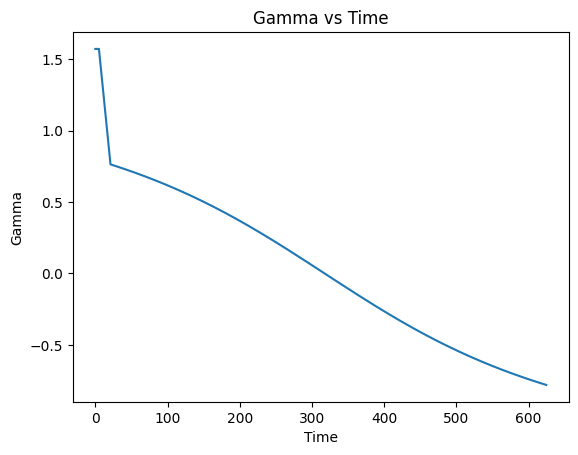

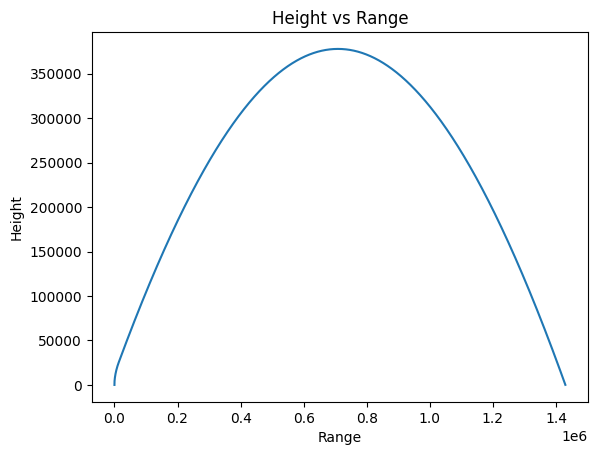

Data written to 'results/results_4.txt'


In [49]:
wirte_output_txt = True


# from emukit.core.initial_designs.latin_design import LatinDesign
# design = LatinDesign(parameter_space) 

m3_design = RandomDesign(m3_space)
m3_x = m3_design.get_samples(5)
m3_y = neg_run_missile_sim(m3_x)


In [50]:
# Build model
m3_var_kernel = (100)**2 
m3_lengthscale = 100 # 1
m3_var_noise = 1e-5 # small value

m3_kern = GPy.kern.RBF(input_dim=nr_custom_params, lengthscale=m3_lengthscale ) + \
    GPy.kern.Linear(input_dim=nr_custom_params)

m3_model_gpy = GPRegression(m3_x,m3_y, kernel=m3_kern)
m3_model_gpy.kern.variance =  m3_var_kernel 
m3_model_gpy.likelihood.variance.fix(m3_var_noise)  

display(m3_model_gpy)





In [51]:
m3_model_emukit = GPyModelWrapper(m3_model_gpy)
m3_model_emukit.optimize()

In [52]:
display(m3_model_gpy)



In [53]:
# # Exact optimization: 
# # - opt1: Greedy: compute simulation on a grid and find maximum
# # - opt2: Minimize package

wirte_output_txt = False
from scipy.optimize import minimize
# # opt2
# func_to_minimize = lambda x: (x[0] - 1)**2 + (x[1] - 2.5)**2  
def func_to_minimize(x):
    print(x)
    return neg_run_missile_sim(np.array(x).reshape(1,nr_custom_params))

# Function taking 6 inputs and returning the -range of the simulation run with those 6 params and 
# the others set as defaut
bnds = [(m3_domain_param_1),
        (m3_domain_param_2),
        (m3_domain_param_3),
        (m3_domain_param_4),
#         (m3_domain_param_5),
#         (m3_domain_param_6)
       ]


initial_guess = [np.mean(m3_domain_param_1),
                 np.mean(m3_domain_param_2),
                 np.mean(m3_domain_param_3),
                 np.mean(m3_domain_param_4),
#                  np.mean(m3_domain_param_5),
#                  np.mean(m3_domain_param_6)
                ]
true_minim = minimize(func_to_minimize, initial_guess, bounds=bnds) # , method='SLSQP'constraints=cons



[ 3250.   450.  2000. 39500.]

New simulation 

fuelmass: 3250.0
Isp0: 450.0
drymass: 2000.0
thrust0: 39500.0


Stage 1 burnout
Velocity (km/s):  3.265595650135737
Angle (deg h):  43.67723082354777
Range (km):  24.478932233595803
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.5961059554932
Apogee (km):  344.1630357716314
Time to target (sec):  598.3000000000675


[ 3250.00000001   450.          2000.         39500.        ]

New simulation 

fuelmass: 3250.00000001
Isp0: 450.0
drymass: 2000.0
thrust0: 39500.0


Stage 1 burnout
Velocity (km/s):  3.2655956501256957
Angle (deg h):  43.6772308237112
Range (km):  24.478932233455883
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.596105948389
Apogee (km):  344.1630357711632
Time to target (sec):  598.3000000000675


[ 3250.           450.00000001  2000.         39500.        ]

New simulation 

fuelmass: 3250.0
Isp0: 450.00000001
drymass: 2000.0
thrust0: 39500.0


Stage 1 burnout
Velocity (km/s):  3.2655956

Final results: 
Range (km):  1265.6399925235085
Apogee (km):  344.16060516101714
Time to target (sec):  598.3000000000675


[ 3249.99842577   449.99029384  1999.99934678 39500.00018692]

New simulation 

fuelmass: 3249.9984257718606
Isp0: 449.99029383713753
drymass: 1999.9993467803713
thrust0: 39500.00018691556


Stage 1 burnout
Velocity (km/s):  3.265643030682358
Angle (deg h):  43.67604972714011
Range (km):  24.479711138787007
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.6399925163946
Apogee (km):  344.16060516054984
Time to target (sec):  598.3000000000675


[ 3249.99842576   449.99029385  1999.99934678 39500.00018692]

New simulation 

fuelmass: 3249.9984257618607
Isp0: 449.99029384713754
drymass: 1999.9993467803713
thrust0: 39500.00018691556


Stage 1 burnout
Velocity (km/s):  3.2656430306457875
Angle (deg h):  43.676049728165445
Range (km):  24.479711138151696
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.6399924796394
Apogee (km):  344.1606

Final results: 
Range (km):  1253.2165005927834
Apogee (km):  340.76330786772985
Time to target (sec):  594.9000000000667


[ 3249.98690522   449.91926242  1999.9945664  39500.0015548 ]

New simulation 

fuelmass: 3249.986905218678
Isp0: 449.91926242030064
drymass: 1999.9945664035754
thrust0: 39500.00155479667


Stage 1 burnout
Velocity (km/s):  3.2506266152005328
Angle (deg h):  43.67761906528585
Range (km):  24.251037006080136
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.216500585744
Apogee (km):  340.76330786727203
Time to target (sec):  594.9000000000667


[ 3249.98690521   449.91926243  1999.9945664  39500.0015548 ]

New simulation 

fuelmass: 3249.9869052086783
Isp0: 449.91926243030065
drymass: 1999.9945664035754
thrust0: 39500.00155479667


Stage 1 burnout
Velocity (km/s):  3.2506266151644514
Angle (deg h):  43.67761906631177
Range (km):  24.251037005451845
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.2165005494428
Apogee (km):  340.7633

Final results: 
Range (km):  1265.855995665978
Apogee (km):  344.14863796299585
Time to target (sec):  598.3000000000675


[ 3249.99067919   449.9425313   1999.99613239 39500.0011067 ]

New simulation 

fuelmass: 3249.99067918761
Isp0: 449.9425312995018
drymass: 1999.9961323868424
thrust0: 39500.00110669832


Stage 1 burnout
Velocity (km/s):  3.2658762360509623
Angle (deg h):  43.67023687114258
Range (km):  24.483544696658985
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8559956588729
Apogee (km):  344.1486379625277
Time to target (sec):  598.3000000000675


[ 3249.99067918   449.94253131  1999.99613239 39500.0011067 ]

New simulation 

fuelmass: 3249.99067917761
Isp0: 449.9425313095018
drymass: 1999.9961323868424
thrust0: 39500.00110669832


Stage 1 burnout
Velocity (km/s):  3.265876236014576
Angle (deg h):  43.67023687216792
Range (km):  24.483544696024875
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8559956221757
Apogee (km):  344.1486379657306

Final results: 
Range (km):  1265.8567730059976
Apogee (km):  344.14859488143367
Time to target (sec):  598.3000000000675


[ 3249.9906513    449.94235944  1999.99612082 39500.00111002]

New simulation 

fuelmass: 3249.990651304277
Isp0: 449.94235944296554
drymass: 1999.9961208209884
thrust0: 39500.00111001783


Stage 1 burnout
Velocity (km/s):  3.265877075328136
Angle (deg h):  43.67021595288223
Range (km):  24.483558492566196
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.856773009718
Apogee (km):  344.14859488385844
Time to target (sec):  598.3000000000675


[ 3249.99065075   449.94235604  1999.99612059 39500.00111007]

New simulation 

fuelmass: 3249.990650751664
Isp0: 449.9423560357594
drymass: 1999.9961205916852
thrust0: 39500.00111007345


Stage 1 burnout
Velocity (km/s):  3.2658770919658218
Angle (deg h):  43.67021553817441
Range (km):  24.48355876606429
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8567884204906
Apogee (km):  344.1485940295

Final results: 
Range (km):  1253.7304681588894
Apogee (km):  342.0955555911375
Time to target (sec):  596.000000000067


[ 3249.942886     449.64787349  1999.97634047 39500.00613838]

New simulation 

fuelmass: 3249.942886004975
Isp0: 449.6478734875088
drymass: 1999.9763404683888
thrust0: 39500.00613838127


Stage 1 burnout
Velocity (km/s):  3.251940136980017
Angle (deg h):  43.77916170608733
Range (km):  24.272618963638255
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.7304681994115
Apogee (km):  342.0955555862169
Time to target (sec):  596.000000000067


[ 3249.942886     449.64787349  1999.97634046 39500.00613839]

New simulation 

fuelmass: 3249.942886004975
Isp0: 449.6478734875088
drymass: 1999.976340458389
thrust0: 39500.00613839127


Stage 1 burnout
Velocity (km/s):  3.251940136991421
Angle (deg h):  43.7791617060746
Range (km):  24.272618963717957
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.730468203101
Apogee (km):  342.0955555886216
T

Final results: 
Range (km):  1253.1409667452126
Apogee (km):  340.7676157937966
Time to target (sec):  594.9000000000667


[ 3249.9896449    449.9361544   1999.99570354 39500.00122417]

New simulation 

fuelmass: 3249.989644899012
Isp0: 449.9361544041417
drymass: 1999.995703543269
thrust0: 39500.001224174994


Stage 1 burnout
Velocity (km/s):  3.2505449416707894
Angle (deg h):  43.67967530532256
Range (km):  24.249694801878178
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1409667381743
Apogee (km):  340.76761579333925
Time to target (sec):  594.9000000000667


[ 3249.98964489   449.93615441  1999.99570354 39500.00122417]

New simulation 

fuelmass: 3249.989644889012
Isp0: 449.9361544141417
drymass: 1999.995703543269
thrust0: 39500.001224174994


Stage 1 burnout
Velocity (km/s):  3.250544941634757
Angle (deg h):  43.67967530634848
Range (km):  24.2496948012501
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1409667018756
Apogee (km):  340.7676157965

Final results: 
Range (km):  1265.8796023604848
Apogee (km):  344.1473295668576
Time to target (sec):  598.3000000000675


[ 3249.9898327    449.93731232  1999.99578132 39500.00120445]

New simulation 

fuelmass: 3249.9898327018623
Isp0: 449.9373123201527
drymass: 1999.9957813174979
thrust0: 39500.001204446475


Stage 1 burnout
Velocity (km/s):  3.2659017230182834
Angle (deg h):  43.669601621020306
Range (km):  24.483963650636753
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.879602364213
Apogee (km):  344.14732956929333
Time to target (sec):  598.3000000000675


[ 3249.98983269   449.93731224  1999.99578131 39500.00120444]

New simulation 

fuelmass: 3249.989832688985
Isp0: 449.9373122407624
drymass: 1999.9957813121655
thrust0: 39500.00120443783


Stage 1 burnout
Velocity (km/s):  3.265901723404455
Angle (deg h):  43.669601611371824
Range (km):  24.483963656992962
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8796027224898
Apogee (km):  344.1473295

Final results: 
Range (km):  1265.8798139410296
Apogee (km):  344.1473178395163
Time to target (sec):  598.3000000000675


[ 3249.98982511   449.93726553  1999.99577818 39500.00120523]

New simulation 

fuelmass: 3249.989825113201
Isp0: 449.937265534045
drymass: 1999.9957781849957
thrust0: 39500.001205234024


Stage 1 burnout
Velocity (km/s):  3.2659019514760717
Angle (deg h):  43.66959592629143
Range (km):  24.483967406222188
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8798139818919
Apogee (km):  344.1473178345654
Time to target (sec):  598.3000000000675


[ 3249.98982511   449.93726553  1999.99577817 39500.00120524]

New simulation 

fuelmass: 3249.989825113201
Isp0: 449.937265534045
drymass: 1999.9957781749958
thrust0: 39500.00120524402


Stage 1 burnout
Velocity (km/s):  3.2659019514875895
Angle (deg h):  43.66959592627867
Range (km):  24.483967406302888
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.87981398563
Apogee (km):  344.1473178370015

Final results: 
Range (km):  1265.8811238666735
Apogee (km):  344.14724521573726
Time to target (sec):  598.3000000000675


[ 3249.98977814   449.93697595  1999.99575872 39500.00121017]

New simulation 

fuelmass: 3249.989778141157
Isp0: 449.9369759489405
drymass: 1999.9957587236404
thrust0: 39500.00121017063


Stage 1 burnout
Velocity (km/s):  3.2659033656128873
Angle (deg h):  43.66956067831617
Range (km):  24.48399065223863
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.881123829977
Apogee (km):  344.1472452189537
Time to target (sec):  598.3000000000675


[ 3249.98977814   449.93697594  1999.99575873 39500.00121017]

New simulation 

fuelmass: 3249.989778141157
Isp0: 449.9369759389405
drymass: 1999.9957587336403
thrust0: 39500.00121017063


Stage 1 burnout
Velocity (km/s):  3.2659033656493137
Angle (deg h):  43.66956067712389
Range (km):  24.483990652949412
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8811238709172
Apogee (km):  344.14724521394

Final results: 
Range (km):  1253.4150044074502
Apogee (km):  340.75483985625635
Time to target (sec):  594.9000000000667


[ 3249.98968656   449.93662358  1999.99570888 39500.00127858]

New simulation 

fuelmass: 3249.989686557659
Isp0: 449.93662358078706
drymass: 1999.9957088782005
thrust0: 39500.00127857527


Stage 1 burnout
Velocity (km/s):  3.250542743100479
Angle (deg h):  43.679731761407204
Range (km):  24.24965827316459
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1389058775542
Apogee (km):  340.767743877834
Time to target (sec):  594.9000000000667


[ 3249.98968657   449.93662358  1999.99570888 39500.00127858]

New simulation 

fuelmass: 3249.9896865676587
Isp0: 449.93662358078706
drymass: 1999.9957088782005
thrust0: 39500.00127857527


Stage 1 burnout
Velocity (km/s):  3.2505427430904996
Angle (deg h):  43.67973176157065
Range (km):  24.249658273025982
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1389058705167
Apogee (km):  340.767743

Final results: 
Range (km):  1253.1383970351542
Apogee (km):  340.7677676460123
Time to target (sec):  594.9000000000667


[ 3249.98972156   449.93673327  1999.99572933 39500.00124552]

New simulation 

fuelmass: 3249.989721563824
Isp0: 449.9367332667356
drymass: 1999.9957293343964
thrust0: 39500.00124551727


Stage 1 burnout
Velocity (km/s):  3.2505421781026747
Angle (deg h):  43.67974543832218
Range (km):  24.249649185403353
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1383970388445
Apogee (km):  340.7677676484034
Time to target (sec):  594.9000000000667


[ 3249.98975657   449.93684295  1999.99574979 39500.00121244]

New simulation 

fuelmass: 3249.9897565697534
Isp0: 449.936842951945
drymass: 1999.9957497904547
thrust0: 39500.00121243949


Stage 1 burnout
Velocity (km/s):  3.265904015074929
Angle (deg h):  43.66954449007273
Range (km):  24.484001328341975
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8817253991251
Apogee (km):  344.1472118677

Final results: 
Range (km):  1265.8817275239292
Apogee (km):  344.1472117720761
Time to target (sec):  598.3000000000675


[ 3249.98975643   449.9368425   1999.99574971 39500.00121258]

New simulation 

fuelmass: 3249.9897564252483
Isp0: 449.9368424991628
drymass: 1999.9957497060118
thrust0: 39500.001212576


Stage 1 burnout
Velocity (km/s):  3.265904017430463
Angle (deg h):  43.66954443361536
Range (km):  24.48400136624528
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8817275239605
Apogee (km):  344.14721177184066
Time to target (sec):  598.3000000000675


[ 3249.98975644   449.9368425   1999.99574971 39500.00121258]

New simulation 

fuelmass: 3249.989756435248
Isp0: 449.9368424991628
drymass: 1999.9957497060118
thrust0: 39500.001212576


Stage 1 burnout
Velocity (km/s):  3.265904017420419
Angle (deg h):  43.66954443377878
Range (km):  24.484001366105353
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8817275168506
Apogee (km):  344.1472117713711
T

Final results: 
Range (km):  1265.8817275252409
Apogee (km):  344.14721177198265
Time to target (sec):  598.3000000000675


[ 3249.98975207   449.93682885  1999.99574716 39500.00121669]

New simulation 

fuelmass: 3249.9897520675704
Isp0: 449.9368288451094
drymass: 1999.9957471595599
thrust0: 39500.001216692406


Stage 1 burnout
Velocity (km/s):  3.265904088462917
Angle (deg h):  43.66954273109241
Range (km):  24.484002509248175
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8817915999357
Apogee (km):  344.14720888019497
Time to target (sec):  598.3000000000675


[ 3249.98975208   449.93682885  1999.99574716 39500.00121669]

New simulation 

fuelmass: 3249.9897520775703
Isp0: 449.9368288451094
drymass: 1999.9957471595599
thrust0: 39500.001216692406


Stage 1 burnout
Velocity (km/s):  3.2659040884528747
Angle (deg h):  43.669542731255845
Range (km):  24.484002509108265
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8817915928169
Apogee (km):  344.1472

Final results: 
Range (km):  1253.1380072054048
Apogee (km):  340.76778585841527
Time to target (sec):  594.9000000000667


[ 3249.98974838   449.93681731  1999.99574501 39500.00122017]

New simulation 

fuelmass: 3249.9897483823115
Isp0: 449.9368173079692
drymass: 1999.9957450060429
thrust0: 39500.001220173624


Stage 1 burnout
Velocity (km/s):  3.2505417452052083
Angle (deg h):  43.67975591751868
Range (km):  24.249642222409594
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1380071691963
Apogee (km):  340.7677858616073
Time to target (sec):  594.9000000000667


[ 3249.98974838   449.9368173   1999.99574502 39500.00122017]

New simulation 

fuelmass: 3249.9897483823115
Isp0: 449.9368172979692
drymass: 1999.9957450160427
thrust0: 39500.001220173624


Stage 1 burnout
Velocity (km/s):  3.25054174524132
Angle (deg h):  43.67975591632931
Range (km):  24.249642223112055
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1380072095953
Apogee (km):  340.76778

Final results: 
Range (km):  1253.1390226206108
Apogee (km):  340.76773842177766
Time to target (sec):  594.9000000000667


[ 3249.98967859   449.93659842  1999.99570419 39500.00128636]

New simulation 

fuelmass: 3249.989678593035
Isp0: 449.9365984165078
drymass: 1999.9957041854773
thrust0: 39500.00128635821


Stage 1 burnout
Velocity (km/s):  3.250542872685795
Angle (deg h):  43.67972862445878
Range (km):  24.24966035747663
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1390225843056
Apogee (km):  340.7677384249914
Time to target (sec):  594.9000000000667


[ 3249.98967859   449.93659841  1999.9957042  39500.00128636]

New simulation 

fuelmass: 3249.989678593035
Isp0: 449.9365984065078
drymass: 1999.9957041954772
thrust0: 39500.00128635821


Stage 1 burnout
Velocity (km/s):  3.2505428727219483
Angle (deg h):  43.67972862326941
Range (km):  24.249660358179256
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1390226247133
Apogee (km):  340.767738420

Final results: 
Range (km):  1253.138510126552
Apogee (km):  340.76776236468845
Time to target (sec):  594.9000000000667


[ 3249.98974904   449.93681936  1999.99574539 39500.00121955]

New simulation 

fuelmass: 3249.9897490417156
Isp0: 449.9368193640599
drymass: 1999.9957453913646
thrust0: 39500.00121955078


Stage 1 burnout
Velocity (km/s):  3.2659041377861553
Angle (deg h):  43.66954154889964
Range (km):  24.484003302923025
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818360927855
Apogee (km):  344.14720687229004
Time to target (sec):  598.3000000000675


[ 3249.98974905   449.93681936  1999.99574539 39500.00121955]

New simulation 

fuelmass: 3249.9897490517155
Isp0: 449.9368193640599
drymass: 1999.9957453913646
thrust0: 39500.00121955078


Stage 1 burnout
Velocity (km/s):  3.2659041377761127
Angle (deg h):  43.669541549065926
Range (km):  24.48400330278144
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818360856058
Apogee (km):  344.1472068

Final results: 
Range (km):  1265.8818360942016
Apogee (km):  344.1472068699155
Time to target (sec):  598.3000000000675


[ 3249.98974904   449.93681936  1999.99574539 39500.00121956]

New simulation 

fuelmass: 3249.989749041417
Isp0: 449.93681936312265
drymass: 1999.99574539119
thrust0: 39500.00121956106


Stage 1 burnout
Velocity (km/s):  3.2659041377925453
Angle (deg h):  43.66954154876937
Range (km):  24.484003303017552
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818360979699
Apogee (km):  344.1472068722863
Time to target (sec):  598.3000000000675


[ 3249.98974901   449.93681927  1999.99574537 39500.00121958]

New simulation 

fuelmass: 3249.9897490106305
Isp0: 449.9368192665633
drymass: 1999.9957453731827
thrust0: 39500.001219580256


Stage 1 burnout
Velocity (km/s):  3.2659041382933878
Angle (deg h):  43.669541536743466
Range (km):  24.484003311084425
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818365503046
Apogee (km):  344.14720685

Final results: 
Range (km):  1265.8818366946202
Apogee (km):  344.1472068443675
Time to target (sec):  598.3000000000675


[ 3249.989749     449.93681924  1999.99574537 39500.00121959]

New simulation 

fuelmass: 3249.9897490003377
Isp0: 449.9368192442808
drymass: 1999.9957453671625
thrust0: 39500.00121959002


Stage 1 burnout
Velocity (km/s):  3.2659041384148613
Angle (deg h):  43.66954153391003
Range (km):  24.484003313011105
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818366579192
Apogee (km):  344.147206847581
Time to target (sec):  598.3000000000675


[ 3249.989749     449.93681923  1999.99574538 39500.00121959]

New simulation 

fuelmass: 3249.9897490003377
Isp0: 449.9368192342808
drymass: 1999.9957453771624
thrust0: 39500.00121959002


Stage 1 burnout
Velocity (km/s):  3.265904138451323
Angle (deg h):  43.66954153271775
Range (km):  24.48400331372202
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818366988587
Apogee (km):  344.14720684258

Final results: 
Range (km):  1265.8818367027377
Apogee (km):  344.1472068449994
Time to target (sec):  598.3000000000675


[ 3249.98974681   449.93681235  1999.99574408 39500.00122167]

New simulation 

fuelmass: 3249.9897468052623
Isp0: 449.93681234957495
drymass: 1999.9957440832488
thrust0: 39500.001221671635


Stage 1 burnout
Velocity (km/s):  3.250541770739355
Angle (deg h):  43.6797552993357
Range (km):  24.249642633141434
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1380301672523
Apogee (km):  340.7677847864854
Time to target (sec):  594.9000000000667


[ 3249.98974682   449.93681235  1999.99574408 39500.00122167]

New simulation 

fuelmass: 3249.989746815262
Isp0: 449.93681234957495
drymass: 1999.9957440832488
thrust0: 39500.001221671635


Stage 1 burnout
Velocity (km/s):  3.2505417707293787
Angle (deg h):  43.67975529949915
Range (km):  24.24964263300287
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1380301602092
Apogee (km):  340.767784

Final results: 
Range (km):  1232.141257816581
Apogee (km):  335.20173899234055
Time to target (sec):  589.2000000000654


[ 3249.27897143   445.55321758  1999.70008828 39500.08434819]

New simulation 

fuelmass: 3249.278971428508
Isp0: 445.55321758125535
drymass: 1999.7000882820892
thrust0: 39500.08434818747


Stage 1 burnout
Velocity (km/s):  3.225755887792773
Angle (deg h):  43.715436852845635
Range (km):  23.898730564215132
Time (sec):  36.70000000000025
Final results: 
Range (km):  1232.141257820309
Apogee (km):  335.2017389946706
Time to target (sec):  589.2000000000654


[ 3249.94271815   449.64676416  1999.97618229 39500.00672001]

New simulation 

fuelmass: 3249.9427181459705
Isp0: 449.6467641615205
drymass: 1999.9761822861572
thrust0: 39500.00672001469


Stage 1 burnout
Velocity (km/s):  3.2519456663118014
Angle (deg h):  43.77902633850495
Range (km):  24.272708519407324
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.7354955986948
Apogee (km):  342.09530921

Final results: 
Range (km):  1253.1380095859245
Apogee (km):  340.76778562296124
Time to target (sec):  594.9000000000667


[ 3249.98974883   449.93681805  1999.99574531 39500.00121956]

New simulation 

fuelmass: 3249.989748834592
Isp0: 449.9368180472989
drymass: 1999.9957453074028
thrust0: 39500.001219564205


Stage 1 burnout
Velocity (km/s):  3.2659041442040735
Angle (deg h):  43.66954138874379
Range (km):  24.484003408489997
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818420421212
Apogee (km):  344.1472065406558
Time to target (sec):  598.3000000000675


[ 3249.98974884   449.93681805  1999.99574531 39500.00121956]

New simulation 

fuelmass: 3249.9897488445918
Isp0: 449.9368180472989
drymass: 1999.9957453074028
thrust0: 39500.001219564205


Stage 1 burnout
Velocity (km/s):  3.2659041441940313
Angle (deg h):  43.66954138891009
Range (km):  24.484003408348418
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818420349323
Apogee (km):  344.147206

Final results: 
Range (km):  1253.7419714189202
Apogee (km):  342.094976582953
Time to target (sec):  596.000000000067


[ 3249.9420329    449.64538013  1999.97608506 39500.00610993]

New simulation 

fuelmass: 3249.9420329006716
Isp0: 449.6453801282444
drymass: 1999.97608506056
thrust0: 39500.00610992518


Stage 1 burnout
Velocity (km/s):  3.2519527425014934
Angle (deg h):  43.77885143187749
Range (km):  24.272824126219362
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.7419714594087
Apogee (km):  342.09497657803144
Time to target (sec):  596.000000000067


[ 3249.9420329    449.64538013  1999.97608505 39500.00610994]

New simulation 

fuelmass: 3249.9420329006716
Isp0: 449.6453801282444
drymass: 1999.9760850505602
thrust0: 39500.00610993518


Stage 1 burnout
Velocity (km/s):  3.251952742513032
Angle (deg h):  43.77885143186191
Range (km):  24.272824126301476
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.7419714632076
Apogee (km):  342.09497658043

Final results: 
Range (km):  1265.8818419982117
Apogee (km):  344.14720654339976
Time to target (sec):  598.3000000000675


[ 3249.98974883   449.93681805  1999.99574532 39500.00121956]

New simulation 

fuelmass: 3249.989748834592
Isp0: 449.936818047299
drymass: 1999.9957453174027
thrust0: 39500.001219564205


Stage 1 burnout
Velocity (km/s):  3.265904144194106
Angle (deg h):  43.669541388743745
Range (km):  24.484003408425117
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818420391594
Apogee (km):  344.1472065384291
Time to target (sec):  598.3000000000675


[ 3249.98974883   449.93681805  1999.99574531 39500.00121957]

New simulation 

fuelmass: 3249.989748834592
Isp0: 449.936818047299
drymass: 1999.9957453074028
thrust0: 39500.0012195742


Stage 1 burnout
Velocity (km/s):  3.2659041442054892
Angle (deg h):  43.66954138873098
Range (km):  24.48400340850504
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818420428581
Apogee (km):  344.147206540832

Final results: 
Range (km):  1265.8818420421214
Apogee (km):  344.14720654065576
Time to target (sec):  598.3000000000675


[ 3249.98974884   449.93681805  1999.99574531 39500.00121956]

New simulation 

fuelmass: 3249.9897488445918
Isp0: 449.936818047299
drymass: 1999.9957453074028
thrust0: 39500.001219564205


Stage 1 burnout
Velocity (km/s):  3.2659041441940313
Angle (deg h):  43.66954138891009
Range (km):  24.484003408348418
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818420349323
Apogee (km):  344.1472065402198
Time to target (sec):  598.3000000000675


[ 3249.98974883   449.93681806  1999.99574531 39500.00121956]

New simulation 

fuelmass: 3249.989748834592
Isp0: 449.93681805729904
drymass: 1999.9957453074028
thrust0: 39500.001219564205


Stage 1 burnout
Velocity (km/s):  3.265904144157543
Angle (deg h):  43.66954138993542
Range (km):  24.484003407713665
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818419982117
Apogee (km):  344.1472065

In [54]:
true_minim

      fun: -1265.6440289367115
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.71878126,  4.39015018,  0.29615734, -0.07366721])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 465
      nit: 5
     njev: 93
   status: 0
  success: True
        x: array([ 3249.98974883,   449.93681805,  1999.99574531, 39500.00121956])

In [55]:
# Bayesian optimization using emulator
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

m3_2_model_emukit = m3_model_emukit

maxim_aquisition = ExpectedImprovement(model=m3_model_emukit)


bayesopt_loop = BayesianOptimizationLoop(model = m3_2_model_emukit,
                                         space = m3_space,
                                         acquisition = maxim_aquisition,
                                         batch_size = 1)

max_iterations = 30
# def neg_run_missile_sim(custom_params):
#     return -run_missile_sim(custom_params)

bayesopt_loop.run_loop(run_missile_sim, max_iterations) # I'm afraid this minimizes
# bayesopt_loop.run_loop(neg_run_missile_sim, max_iterations) # Not sure if enough




New simulation 

fuelmass: 6000.0
Isp0: 800.0
drymass: 3000.0
thrust0: 10000.0


Stage 1 burnout
Velocity (km/s):  4.596761609049112
Angle (deg h):  43.655695788175954
Range (km):  334.2348153252298
Time (sec):  480.00000000004064
Final results: 
Range (km):  3584.7870765789025
Apogee (km):  1291.2147023904006
Time to target (sec):  1668.2999999995782



New simulation 

fuelmass: 500.0
Isp0: 800.0
drymass: 3000.0
thrust0: 69000.0


Stage 1 burnout
Velocity (km/s):  0.9603298373184243
Angle (deg h):  49.256882113354784
Range (km):  0.27648613467736366
Time (sec):  5.799999999999996
Final results: 
Range (km):  96.22520463917222
Apogee (km):  29.984673933687212
Time to target (sec):  159.7999999999952



New simulation 

fuelmass: 1623.1818719104542
Isp0: 749.253591427864
drymass: 2308.300581406518
thrust0: 21017.304890375264


Stage 1 burnout
Velocity (km/s):  2.7816388695443752
Angle (deg h):  43.69557660605892
Range (km):  34.733955432886425
Time (sec):  57.90000000000055
Final resu


New simulation 

fuelmass: 5985.020330847384
Isp0: 422.1464094014388
drymass: 1080.4936137386892
thrust0: 49506.60953266118


Stage 1 burnout
Velocity (km/s):  6.238981606073539
Angle (deg h):  43.683382019330836
Range (km):  56.8677857325427
Time (sec):  51.100000000000456
Final results: 
Range (km):  5767.143487774687
Apogee (km):  1851.2064347311346
Time to target (sec):  1815.1999999994446



New simulation 

fuelmass: 3981.995904196911
Isp0: 657.3039347071197
drymass: 1467.814228253598
thrust0: 54216.31551288765


Stage 1 burnout
Velocity (km/s):  6.950402144905391
Angle (deg h):  43.73165780457316
Range (km):  64.62181108162609
Time (sec):  48.300000000000416
Final results: 
Range (km):  7666.507296153552
Apogee (km):  2749.0610352190574
Time to target (sec):  2469.2999999988497



New simulation 

fuelmass: 4566.399206671713
Isp0: 220.24206570871357
drymass: 2647.8692430127685
thrust0: 45250.202002295904


Stage 1 burnout
Velocity (km/s):  1.6518214721359379
Angle (deg h):  43.

In [56]:
results = bayesopt_loop.get_results()
results

In [57]:
results.__dict__

{'minimum_location': array([ 4092.21668855,   644.65138967,  2434.52690473, 16450.57190147]),
 'minimum_value': -3059.1812357620765,
 'best_found_value_per_iteration': array([ -331.7868696 , -3059.18123576, -3059.18123576, -3059.18123576,
        -3059.18123576, -3059.18123576, -3059.18123576, -3059.18123576,
        -3059.18123576, -3059.18123576, -3059.18123576, -3059.18123576,
        -3059.18123576, -3059.18123576, -3059.18123576, -3059.18123576,
        -3059.18123576, -3059.18123576, -3059.18123576, -3059.18123576,
        -3059.18123576, -3059.18123576, -3059.18123576, -3059.18123576,
        -3059.18123576, -3059.18123576, -3059.18123576, -3059.18123576,
        -3059.18123576, -3059.18123576, -3059.18123576, -3059.18123576,
        -3059.18123576, -3059.18123576, -3059.18123576])}

## Sensitivity Analysis

In [58]:
rescale_0_1 = True


m4_param_1 = 'fuelmass'
m4_param_2 = 'Isp0'
m4_param_3 = 'drymass'
m4_param_4 = 'thrust0'
# m4_param_5 = 'payload'
# m4_param_6 = 'missilediam'
# I am not sure 'estrange' and 'rvdiam' can be changed freely

m4_domain_param_1 = basic_param_spaces[m4_param_1] # [500, 6000] # [5000,15000]
m4_domain_param_2 = basic_param_spaces[m4_param_2] # [200, 300] # [224, 228]
m4_domain_param_3 = basic_param_spaces[m4_param_3] 
m4_domain_param_4 = basic_param_spaces[m4_param_4] 
# m4_domain_param_5 = basic_param_spaces[m4_param_5] 
# m4_domain_param_6 = basic_param_spaces[m4_param_6] 

if rescale_0_1:
    m4_domain_param_1 = [0,1]
    m4_domain_param_2 = [0,1]
    m4_domain_param_3 = [0,1]
    m4_domain_param_4 = [0,1]
#     m4_domain_param_5 = [0,1]
#     m4_domain_param_6 = [0,1]
    


m4_space = ParameterSpace(
          [ContinuousParameter(m4_param_1, *m4_domain_param_1), 
           ContinuousParameter(m4_param_2, *m4_domain_param_2),
           ContinuousParameter(m4_param_3, *m4_domain_param_3), 
           ContinuousParameter(m4_param_4, *m4_domain_param_4),
#            ContinuousParameter(m4_param_5, *m4_domain_param_5), 
#            ContinuousParameter(m4_param_6, *m4_domain_param_6),
          ])
custom_param_names = [m4_param_1, m4_param_2, 
                      m4_param_3, m4_param_4, 
#                       m4_param_5, m4_param_6
                     ]
nr_custom_params = len(custom_param_names)

In [59]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION (Re-run since custom_param_names has changed)
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
                
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y


if rescale_0_1:
    def scale_back_original(param_value, param_name):
        original_val_ranges = basic_param_spaces[param_name]
        return original_val_ranges[0] + param_value *(original_val_ranges[1]-original_val_ranges[0])
        
    
    def run_missile_sim(custom_params):
        """
        Recives in input an array of custom parameters.
        Each row represents a set of different parameters
        Each column is a different parameter (#cols = len(custom_param_names))
        """
        default_params_IRAQ = {
            'payload':500,
            'missilediam':0.88,
            'rvdiam':0,
            'estrange':600,
            'numstages':1,
            'fuelmass':[0,5600],
            'drymass':[0,1200],
            'Isp0':[0,226],
            'thrust0':[0,9177.4]
        }


        y = np.zeros((custom_params.shape[0], 1))
        for i in range(custom_params.shape[0]):
            params_to_use = default_params_IRAQ
            # Overwrite default param variables
            for j in range(custom_params.shape[1]):
                param_name = custom_param_names[j]
                if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                    params_to_use[param_name][1] = scale_back_original(custom_params[i,j], param_name)
                else:
                    params_to_use[param_name] = scale_back_original(custom_params[i,j], param_name)

                ## TEMP ## Better customise this
                if j==0:
                    print('\nNew simulation \n')
                str_to_print = param_name + ': ' + str(scale_back_original(custom_params[i,j], param_name))
                print(str_to_print)
                ## 

            # Run simulation
            output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
            sim_output = run_one_sim(
                numstages=params_to_use["numstages"], 
                fuelmass=params_to_use["fuelmass"], 
                drymass=params_to_use["drymass"], 
                thrust0=params_to_use["thrust0"], 
                Isp0=params_to_use["Isp0"], 
                payload=params_to_use["payload"],  
                missilediam=params_to_use["missilediam"],  
                rvdiam=params_to_use["rvdiam"], 
                est_range=params_to_use["estrange"], 
                output_path=output_path, 
                simulation_output=simulation_output,
            )

            y[i, 0] = sim_output
        return y




### 1. On the simulator

In [60]:
# # WILL PROBABLY TAKE A LOOONG TIME
wirte_output_txt = False

if run_sensitivity_with_simulator:
    num_mc = 10000 # Probably better to reduce
    senstivity = MonteCarloSensitivity(model = run_missile_sim, input_domain = m4_space)
    main_effects, total_effects, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

In [61]:
if run_sensitivity_with_simulator:
    fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

    main_effects_plot = {ivar: main_effects[ivar][0] for ivar in main_effects}

    d = {'Monte Carlo':main_effects_plot}

    pd.DataFrame(d).plot(kind='bar', ax=ax)
    plt.ylabel('% of explained output variance')

    if write_images:
        mlai.write_figure(filename='first-order-sobol-indices-missile.svg', directory='./uq')



In [62]:
if run_sensitivity_with_simulator:
    fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

    total_effects_plot = {ivar: total_effects[ivar][0] for ivar in total_effects}

    d = {'Monte Carlo':total_effects_plot}

    pd.DataFrame(d).plot(kind='bar', ax=ax)
    ax.set_ylabel('% of explained output variance')

    if write_images:
        mlai.write_figure(filename='total-effects-sobol-indices-missile.svg', directory='./uq')

### 2. On the emulator

#### Build emulator


New simulation 

fuelmass: 4690.219388690231
Isp0: 395.13080351628804
drymass: 1062.1731979606989
thrust0: 66419.29062576496


Stage 1 burnout
Velocity (km/s):  5.017360772516247
Angle (deg h):  43.65543561714252
Range (km):  25.339505050602654
Time (sec):  27.90000000000013
Final results: 
Range (km):  3280.344304389926
Apogee (km):  925.6785636161837
Time to target (sec):  1098.0000000000969




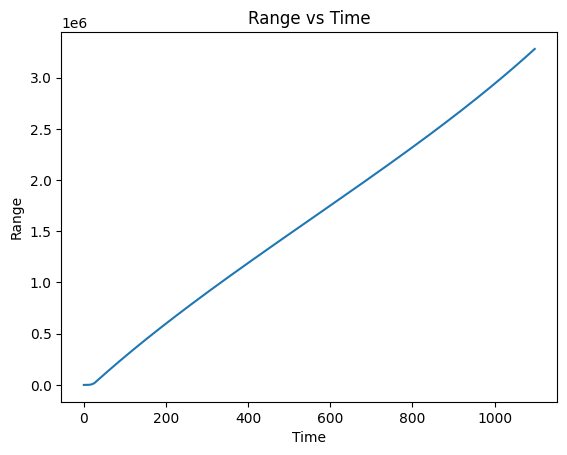

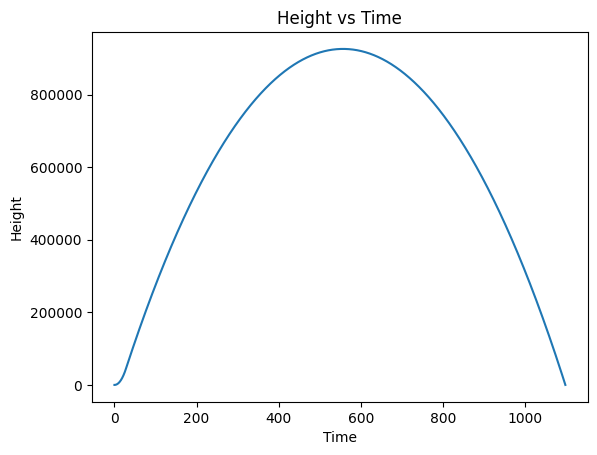

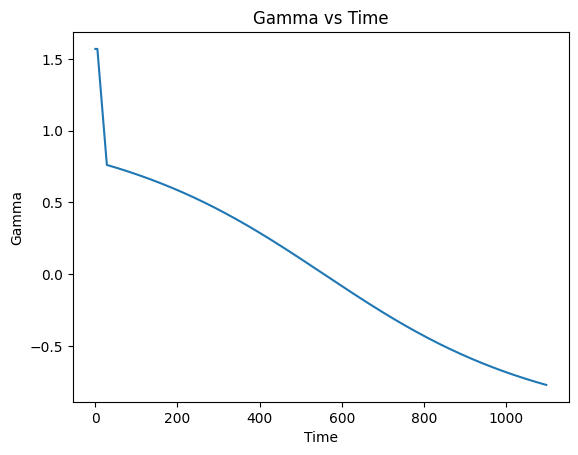

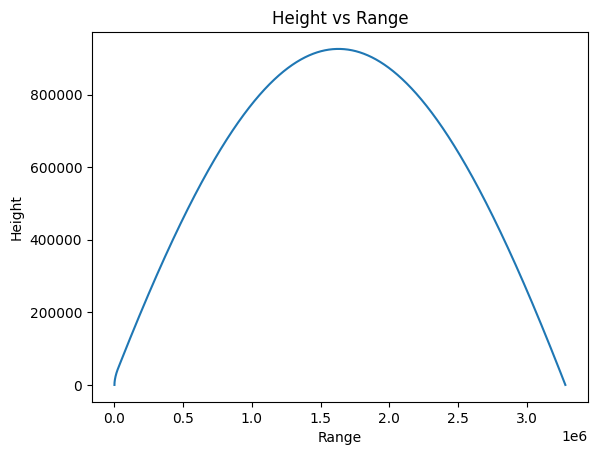

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 3386.963763209411
Isp0: 738.0147590236476
drymass: 2702.0391512715114
thrust0: 29814.53367732501


Stage 1 burnout
Velocity (km/s):  4.739514943034075
Angle (deg h):  43.668682516269556
Range (km):  81.36260216165563
Time (sec):  83.89999999999951
Final results: 
Range (km):  3059.7566465606906
Apogee (km):  913.3971231366996
Time to target (sec):  1108.5000000000873




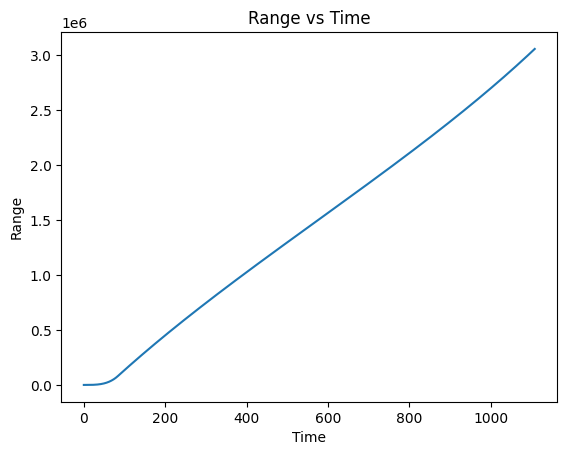

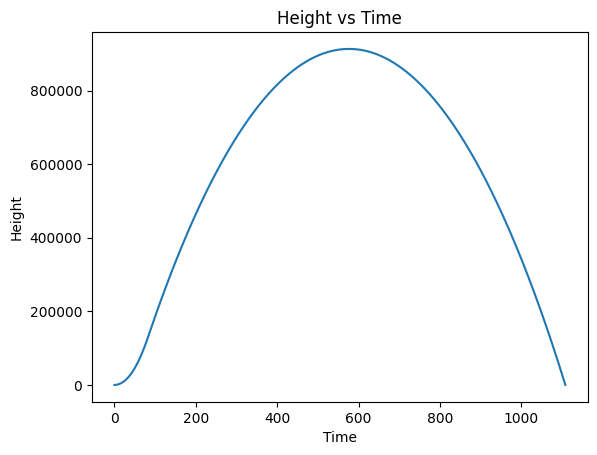

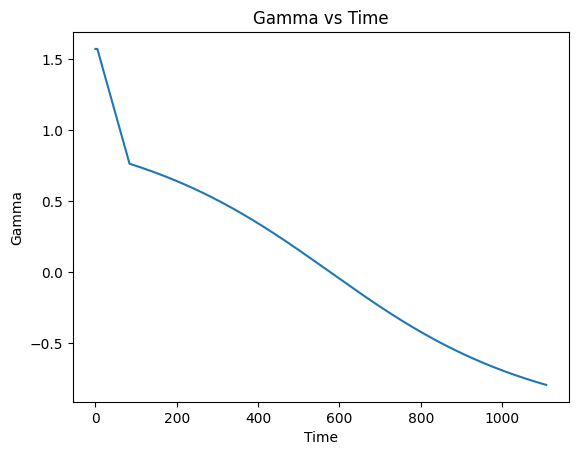

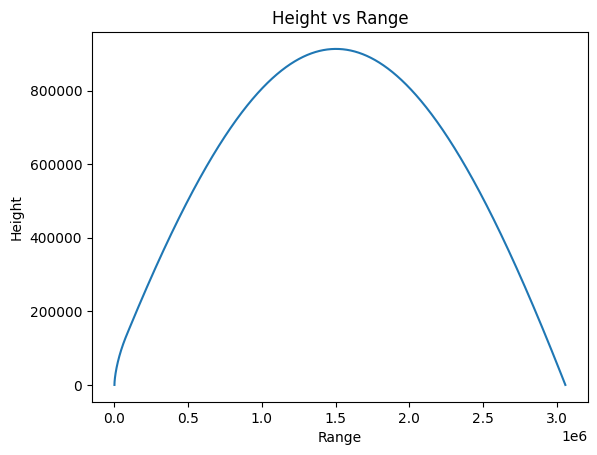

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 3255.290975965315
Isp0: 450.71734525370533
drymass: 2777.789539883313
thrust0: 30400.05901571066


Stage 1 burnout
Velocity (km/s):  2.5645799948410106
Angle (deg h):  43.70493056022044
Range (km):  25.793449375008656
Time (sec):  48.300000000000416
Final results: 
Range (km):  782.8495707154998
Apogee (km):  220.5035624665616
Time to target (sec):  473.6000000000392




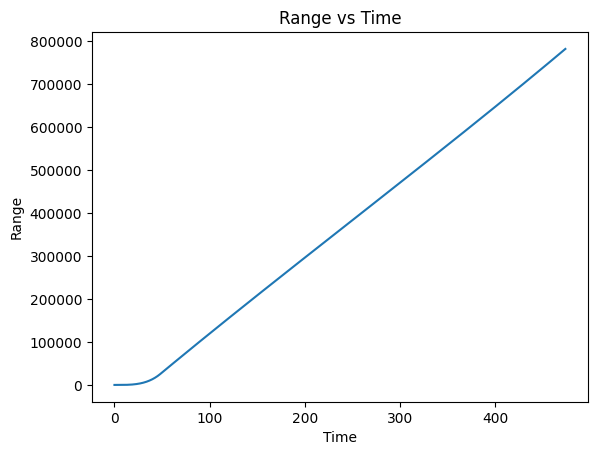

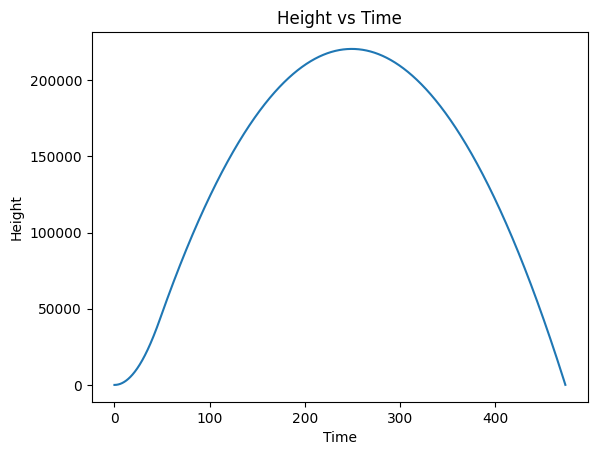

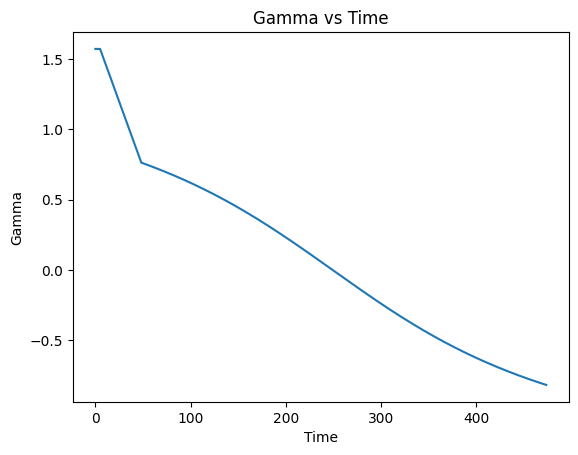

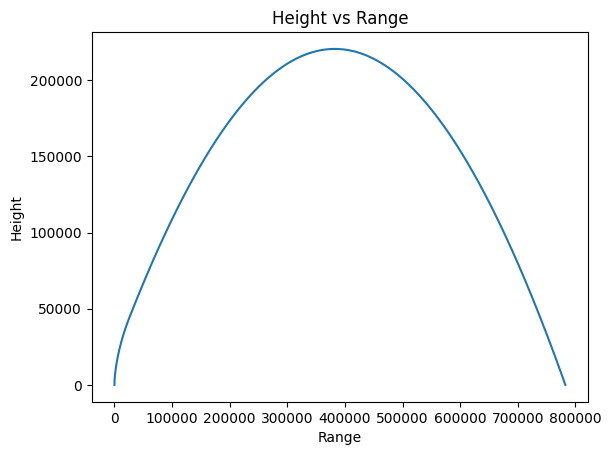

Data written to 'results/results_2.txt'

New simulation 

fuelmass: 4439.681767413926
Isp0: 534.5152286979039
drymass: 1887.2319033669849
thrust0: 48765.126416373576


Stage 1 burnout
Velocity (km/s):  5.168606175169747
Angle (deg h):  43.713752331349085
Range (km):  49.23392015851401
Time (sec):  48.70000000000042
Final results: 
Range (km):  3607.962170697292
Apogee (km):  1056.677950086938
Time to target (sec):  1208.2999999999965




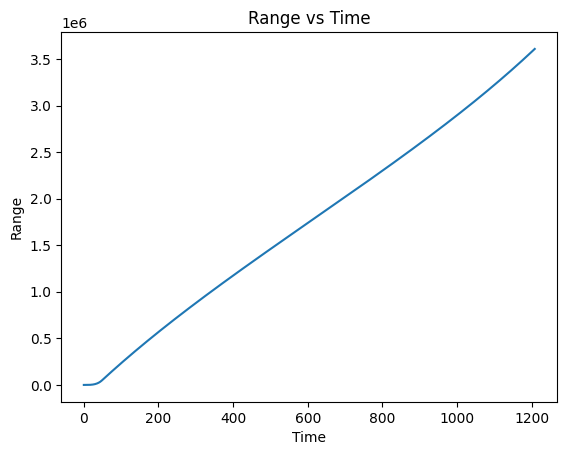

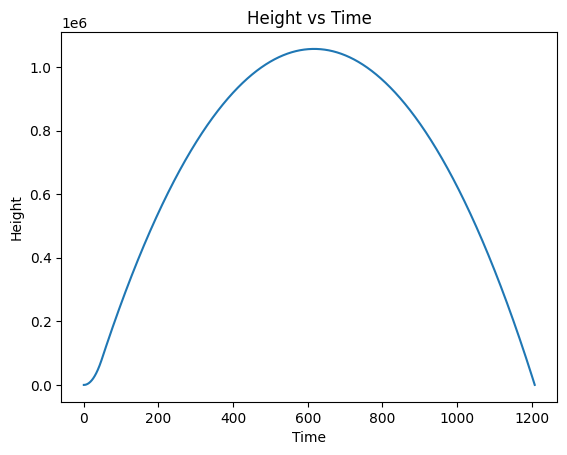

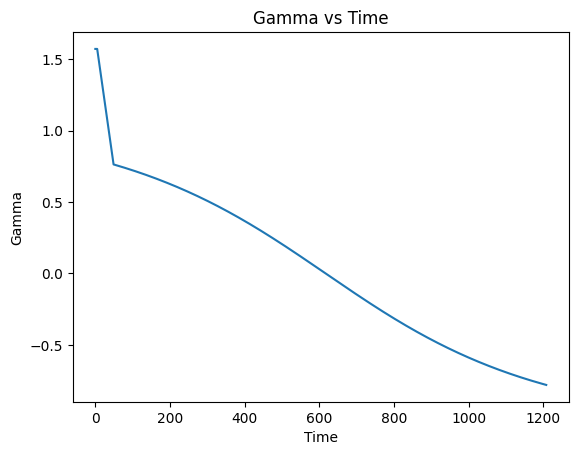

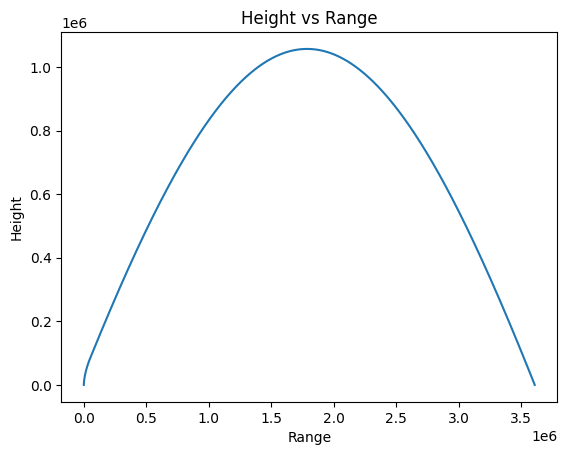

Data written to 'results/results_3.txt'

New simulation 

fuelmass: 2544.0375231383427
Isp0: 485.0378457364407
drymass: 2700.866136425824
thrust0: 14260.8483599344


Stage 1 burnout
Velocity (km/s):  2.000379772339083
Angle (deg h):  43.647711185508776
Range (km):  36.123613954670645
Time (sec):  86.59999999999935
Final results: 
Range (km):  516.9912960433055
Apogee (km):  163.57600164948613
Time to target (sec):  428.0000000000288




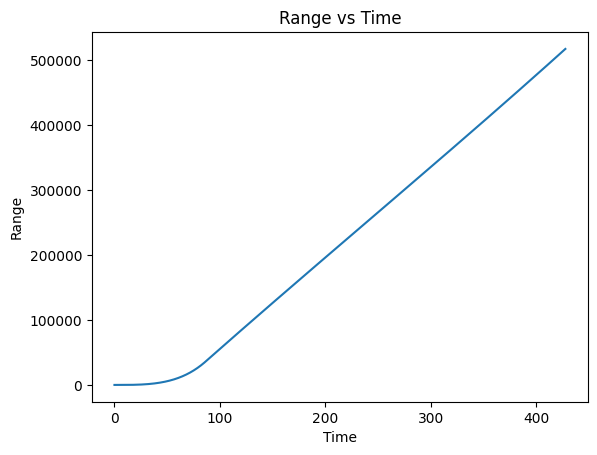

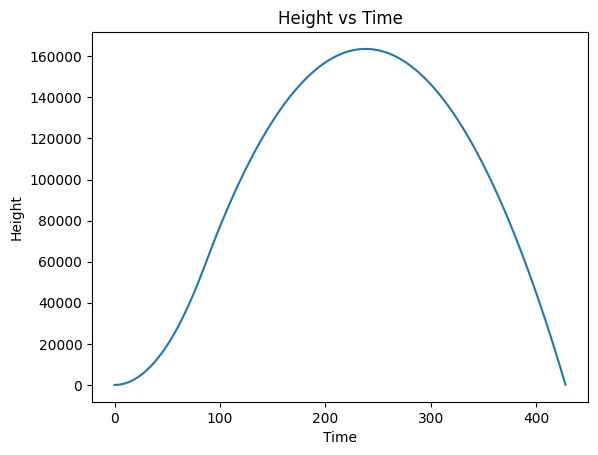

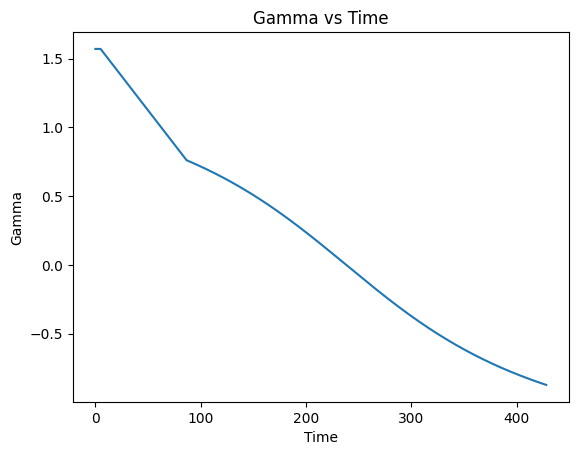

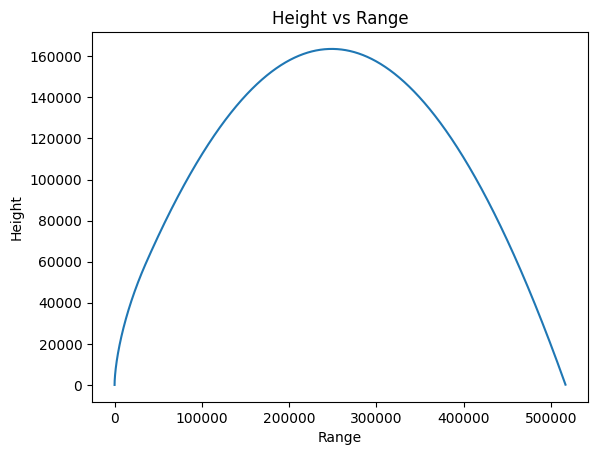

Data written to 'results/results_4.txt'


In [63]:
wirte_output_txt = True


# from emukit.core.initial_designs.latin_design import LatinDesign
# design = LatinDesign(parameter_space) 

m4_design = RandomDesign(m4_space)
m4_x = m4_design.get_samples(5)
m4_y = neg_run_missile_sim(m4_x)



In [64]:
# Build model
m4_var_kernel = (100)**2 
m4_lengthscale = 100 # 1
m4_var_noise = 1e-5 # small value

m4_kern = GPy.kern.RBF(input_dim=nr_custom_params, lengthscale=m4_lengthscale ) + \
    GPy.kern.Linear(input_dim=nr_custom_params)

m4_model_gpy = GPRegression(m4_x,m4_y, kernel=m4_kern)
m4_model_gpy.kern.variance =  m4_var_kernel 
m4_model_gpy.likelihood.variance.fix(m4_var_noise)  

display(m4_model_gpy)






In [65]:
m4_model_emukit = GPyModelWrapper(m4_model_gpy)
m4_model_emukit.optimize()

display(m4_model_gpy)

In [66]:
m4_2_model_emukit = m4_model_emukit

In [67]:
# Experimental design to improve emulator
wirte_output_txt = False

integrated_variance = IntegratedVarianceReduction(space=m4_space,
                                                  model=m4_model_emukit)
m4_ed = ExperimentalDesignLoop(space=m4_space, 
                            model=m4_2_model_emukit, 
                            acquisition = integrated_variance,
                            batch_size = 1) 
# bach size is set to one in this example as we’ll collect evaluations 
# sequentially but parallel evaluations are allowed
m4_ed.run_loop(user_function=run_missile_sim, stopping_condition=10)




New simulation 

fuelmass: 955.7871472747815
Isp0: 427.53986994356404
drymass: 1751.4977546164032
thrust0: 66542.6821743094


Stage 1 burnout
Velocity (km/s):  1.361146810826104
Angle (deg h):  45.285995132084665
Range (km):  0.6011484003443508
Time (sec):  6.199999999999995
Final results: 
Range (km):  196.2769727514333
Apogee (km):  52.71955502658412
Time to target (sec):  212.6999999999922



New simulation 

fuelmass: 1237.2168639930733
Isp0: 643.5788232266162
drymass: 1238.5515921798087
thrust0: 10307.101110697451


Stage 1 burnout
Velocity (km/s):  2.6349684469421635
Angle (deg h):  43.67090004623632
Range (km):  42.73158850001102
Time (sec):  77.29999999999988
Final results: 
Range (km):  870.1575450228762
Apogee (km):  259.7273848008319
Time to target (sec):  531.7000000000523



New simulation 

fuelmass: 4718.154536943029
Isp0: 104.88293818891908
drymass: 1765.3381485848977
thrust0: 23430.36504502503


Stage 1 burnout
Velocity (km/s):  0.9061582833332266
Angle (deg h):  43.6

#### Run sensitivity

In [68]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model = m4_2_model_emukit, input_domain = m4_space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

In [69]:
import matplotlib.pyplot as plt
import mlai.plot as plot
import mlai

In [70]:
import pandas as pd


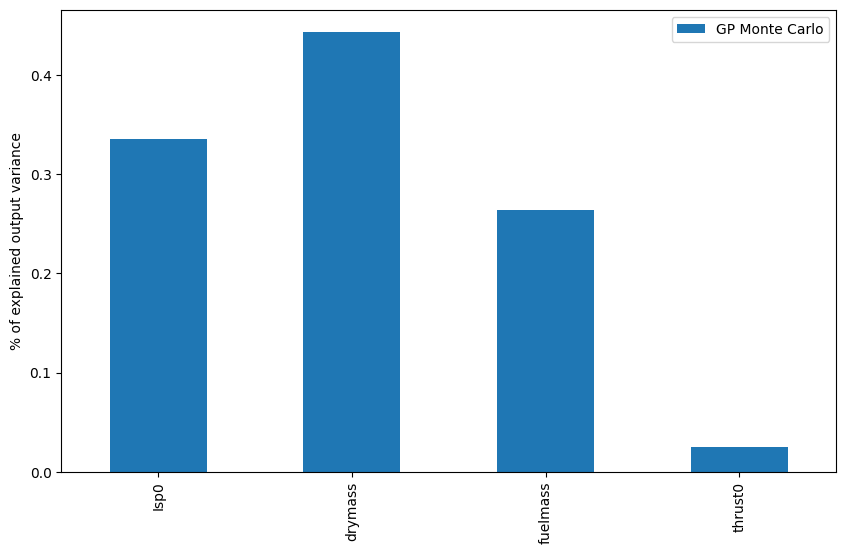

In [71]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

d = {'GP Monte Carlo':main_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
plt.ylabel('% of explained output variance')

if write_images:
    mlai.write_figure(filename='first-order-sobol-indices-gp-missile.svg', directory='./uq')


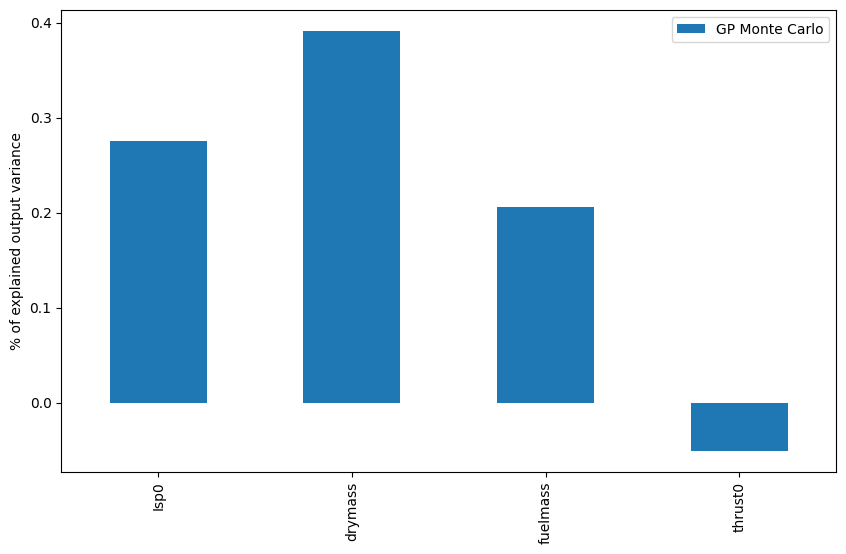

In [72]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}

d = {'GP Monte Carlo':total_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
ax.set_ylabel('% of explained output variance')

if write_images:
    mlai.write_figure(filename='total-effects-sobol-indices-gp-missile.svg', directory='./uq')